Title 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import shap
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv('/Users/mallorygo/Desktop/DATA1030/data1030-fall2025/final reports/ufc-master.csv')
pd.set_option("display.max_columns", None, "display.max_rows", None)

print(df.head())

#{"username":"mallorygo","key":"ed18f8bdde610ec028f2f9d9b03e6bbe"}


In [ ]:
pd.set_option("display.max_columns", None, "display.max_rows", None)

print(df.dtypes) 
# How many rows and columns do we have in df_merge?
print(df.shape[0]) # number of rows
print(df.shape[1]) # number of rows

print(len(df))

In [ ]:
comm_drop = [
'Date','Location'
]
df.drop(comm_drop, axis=1, inplace = True)


print(df.dtypes) 
print(df.shape[0]) # number of rows
print(df.shape[1]) # number of rows

print(len(df))

In [ ]:
#Separating the features based on their data types
cat_col = [col for col in df.columns if df[col].dtypes == 'object']
num_col = [col for col in df.columns if col not in cat_col]
print(df['Winner'].value_counts(dropna=False))


In [ ]:
#take care of missingness in Winner
print("Unique values in Winner column:", df['Winner'].unique())
# Strip spaces and lowercase all values
df['Winner'] = df['Winner'].astype(str).str.strip().str.capitalize()
print("Cleaned Winner values:", df['Winner'].unique())
df = df[df['Winner'].isin(['Red', 'Blue'])]
print("Rows remaining after filtering:", len(df))



In [ ]:
unique_categorieswc = df['WeightClass'].unique()
print(unique_categorieswc)

In [ ]:
from sklearn.preprocessing import LabelEncoder
print(df['Winner'].value_counts(dropna=False))
# Convert 'Red' and 'Blue' winner string to binary label (1 = Red wins, 0 = Blue wins)
df = df[df['Winner'].isin(['Red', 'Blue'])]  # filter out 'Draw' or 'No Contest'
print("Rows remaining after filtering:", len(df))

cat_col = ['RedFighter', 'BlueFighter', 'WeightClass', 'Gender']

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

for col in cat_col:
    if col in df.columns:
        df[col] = enc.fit_transform(df[col].astype(str))
    else:
        print(f"Warning: Column {col} not found in dataframe.")

print(df['Winner'].value_counts())
#Series([], Name: count, dtype: int64)

# result = 
# Series([], Name: count, dtype: int64)
# Rows remaining after filtering: 0
# Series([], Name: count, dtype: int64)

In [ ]:

win_counts = df['Winner'].value_counts()
# Display the frequency table
print("Frequency Table for 'Winner' column:")
print(win_counts)

In [ ]:
for column in df.columns:
    if df[column].isnull().sum()!=0:
        print(f"Nan in {column}: {df[column].isnull().sum()}")

In [ ]:

#force numeric WeightClass if it's not already
df['WeightClass'] = pd.to_numeric(df['WeightClass'], errors='coerce')

weightclass_labels = {
    0: 'Flyweight',
    1: 'Welterweight',
    2: 'Heavyweight',
    3: 'Featherweight',
    4: 'Light Heavyweight',
    5: 'Catch Weight',
    6: 'Lightweight',
    7: 'Bantamweight',
    8: "Women's Strawweight",
    9: "Women's Flyweight",
    10: "Middleweight",  
    11: "Women's Bantamweight",     
    12: "Women's Featherweight "               
}



df['WeightClassLabel'] = df['WeightClass'].map(weightclass_labels)

#check
missing_wtclass = df['WeightClass'].isnull().sum()
print(f"✅ WeightClass mapped. Missing values: {missing_wtclass}")


In [ ]:
# Basic descriptive statistics
print(df.describe())

# Check class balance
sns.countplot(x='Winner', data=df)
plt.title('Fight Winner Distribution (Red = 1, Blue = 0)')
plt.show()

# Missing data heatmap
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()
print(df["BlueHeightCms"])


In [ ]:
#print("Unique values in WeightClass column:", df['WeightClass'].unique())


In [ ]:
#print(df["BlueHeightCms"])


In [ ]:
import numpy as np
df["BlueHeight"] = df["BlueHeightCms"] / 2.54
df['BlueReach']= df['BlueReachCms'] / 2.54
df['RedHeight'] = df['RedHeightCms'] / 2.54
df['RedReach']= df['RedReachCms'] / 2.54
df.drop(columns = ['BlueHeightCms', 'BlueReachCms', 'RedHeightCms', 'RedReachCms'], axis = 1, inplace = True)

df['ROver35'] = df['RedAge'].apply(lambda x: int(x > 37))
df['BOver35'] = df['BlueAge'].apply(lambda x: int(x > 37))

df['RWinPct'] = df['RedWins'] / (df['RedWins'] + df['RedLosses'])
df['BWinPct'] = df['BlueWins'] / (df['BlueWins'] + df['BlueLosses'])

df['RedStrikingRatio'] = df['RedAvgSigStrLanded'] / (df['RedAvgSigStrLanded'] + df['BlueAvgSigStrLanded'])
df['BlueStrikingRatio'] = df['BlueAvgSigStrLanded'] / (df['RedAvgSigStrLanded'] + df['BlueAvgSigStrLanded'])

df['RedTotalFights'] = df['RedWins'] + df['RedLosses']
df['BlueTotalFights'] = df['BlueWins'] + df['BlueLosses']

df['RedIsGrappler'] = (df['RedAvgTDLanded'] > 3.5).astype(int)
df['BlueIsGrappler'] = (df['BlueAvgTDLanded'] > 3.5).astype(int)

df['RedIsStriker'] = (df['RedAvgSigStrLanded'] > 6.0).astype(int)
df['BlueIsStriker'] = (df['BlueAvgSigStrLanded'] > 6.0).astype(int)

df['RGrapplerVBStriker'] = ((df['RedIsGrappler'] == 1) & (df['BlueIsStriker'] == 1)).astype(int)
df['BGrapplerVRStriker'] = ((df['BlueIsGrappler'] == 1) & (df['RedIsStriker'] == 1)).astype(int)

df['RedStrikingEfficiency'] = df['RedAvgSigStrLanded'] * df['RedAvgSigStrPct']
df['BlueStrikingEfficiency'] = df['BlueAvgSigStrLanded'] * df['BlueAvgSigStrPct']

df['RedTDEfficiency'] = df['RedAvgTDLanded'] * df['RedAvgTDPct']
df['BlueTDEfficiency'] = df['BlueAvgTDLanded'] * df['BlueAvgTDPct']

df['RedEffectiveTD'] = 1 / (df['RedAvgTDLanded'] / df['RedAvgSubAtt'])
df['BlueEffectiveTD'] = 1 / (df['BlueAvgTDLanded'] / df['BlueAvgSubAtt'])
df['EffectiveTDDif'] = df['BlueEffectiveTD'] - df['RedEffectiveTD']

df['RedSize'] = df['RedHeight'] + df['RedReach']
df['BlueSize'] = df['BlueHeight'] + df['BlueReach']

df['Favorite'] = (df['RedOdds'] < df['BlueOdds']).astype(int)

df['Favorite'] = df['Favorite'].map({0 : 'Blue', 1 : 'Red'})

df['FavoriteWins'] = (df['Favorite'] == df['Winner']).astype(int)

In [192]:
df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Country,Winner,TitleBout,WeightClass,Gender,NumberOfRounds,BlueCurrentLoseStreak,BlueCurrentWinStreak,BlueDraws,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueLongestWinStreak,BlueLosses,BlueTotalRoundsFought,BlueTotalTitleBouts,BlueWinsByDecisionMajority,BlueWinsByDecisionSplit,BlueWinsByDecisionUnanimous,BlueWinsByKO,BlueWinsBySubmission,BlueWinsByTKODoctorStoppage,BlueWins,BlueStance,BlueWeightLbs,RedCurrentLoseStreak,RedCurrentWinStreak,RedDraws,RedAvgSigStrLanded,RedAvgSigStrPct,RedAvgSubAtt,RedAvgTDLanded,RedAvgTDPct,RedLongestWinStreak,RedLosses,RedTotalRoundsFought,RedTotalTitleBouts,RedWinsByDecisionMajority,RedWinsByDecisionSplit,RedWinsByDecisionUnanimous,RedWinsByKO,RedWinsBySubmission,RedWinsByTKODoctorStoppage,RedWins,RedStance,RedWeightLbs,RedAge,BlueAge,LoseStreakDif,WinStreakDif,LongestWinStreakDif,WinDif,LossDif,TotalRoundDif,TotalTitleBoutDif,KODif,SubDif,HeightDif,ReachDif,AgeDif,SigStrDif,AvgSubAttDif,AvgTDDif,EmptyArena,BMatchWCRank,RMatchWCRank,RWFlyweightRank,RWFeatherweightRank,RWStrawweightRank,RWBantamweightRank,RHeavyweightRank,RLightHeavyweightRank,RMiddleweightRank,RWelterweightRank,RLightweightRank,RFeatherweightRank,RBantamweightRank,RFlyweightRank,RPFPRank,BWFlyweightRank,BWFeatherweightRank,BWStrawweightRank,BWBantamweightRank,BHeavyweightRank,BLightHeavyweightRank,BMiddleweightRank,BWelterweightRank,BLightweightRank,BFeatherweightRank,BBantamweightRank,BFlyweightRank,BPFPRank,BetterRank,Finish,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,WeightClassLabel,BlueHeight,BlueReach,RedHeight,RedReach,ROver35,BOver35,RWinPct,BWinPct,RedStrikingRatio,BlueStrikingRatio,RedTotalFights,BlueTotalFights,RedIsGrappler,BlueIsGrappler,RedIsStriker,BlueIsStriker,RGrapplerVBStriker,BGrapplerVRStriker,RedStrikingEfficiency,BlueStrikingEfficiency,RedTDEfficiency,BlueTDEfficiency,RedEffectiveTD,BlueEffectiveTD,EffectiveTDDif,RedSize,BlueSize,Favorite,FavoriteWins,draw_diff,avg_sig_str_pct_diff,avg_TD_pct_diff,win_by_Decision_Majority_diff,win_by_Decision_Split_diff,win_by_Decision_Unanimous_diff,win_by_TKO_Doctor_Stoppage_diff,odds_diff,ev_diff,StanceCombo,AgeGap,Spread
0,66,1009,-250.0,215.0,40.0000,215.0,USA,1,True,3,1,5,0,0,0,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,Orthodox,125,0,6,0,4.41,0.49,0.8,2.61,0.47,6,3,42,3,0,2,4,2,4,0,12,Orthodox,125,34,31,0,-6,-6,-12,-3,-42,-3,-2,-4,7.62,5.08,-3,-4.41,-0.8,-2.61,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,SUB,Rear Naked Choke,2.0,2:05,425.0,300.0,800.0,150.0,2500.0,400.0,350.0,Featherweight,68.0,69.0,65.0,67.0,0,0,0.800000,NaN,1.000000,0.000000,15,0,0,0,0,0,0,0,2.1609,0.0000,1.2267,0.0000,0.306513,NaN,NaN,132.0,137.0,Red,1,0,-0.49,-0.47,0,-2,-4,0,465.0,175.0000,Orthodox vs Orthodox,3,465.0
1,1441,718,-210.0,295.0,47.6190,295.0,USA,1,False,8,1,3,0,8,0,5.50,0.55,0.3,0.77,0.55,8,0,20,0,0,1,4,3,0,0,8,Orthodox,170,0,6,0,4.12,0.61,1.8,1.49,0.29,6,0,11,0,0,0,0,1,5,0,6,Orthodox,170,30,27,0,2,2,2,0,9,0,2,-5,5.08,-7.62,-3,1.38,-1.5,-0.72,NaN,7.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,Red,U-DEC,NaN,5.0,5:00,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0,Women's Strawweight,75.0,74.0,73.0,77.0,0,0,1.000000,1.000000,0.428274,0.571726,6,8,0,0,0,0,0,0,2.5132,3.0250,0.4321,0.4235,1.208054,0.389610,-0.818443,150.0,149.0,Red,1,0,-0.06,0.26,0,1,4,0,505.0,247.3810,Orthodox vs Orthodox,3,505.0
2,307,67,-380.0,300.0,26.3158,300.0,USA,1,False,4,1,3,0,4,0,5.13,0.57,0.2,0.45,0.63,4,4,44,0,0,1,4,6,1,0,12,Orthodox,250,0,1,0,5.49,0.60,0.5,0.58,0.21,7,2,33,3,0,0,3,4,2,0,9,Orthodox,245,34,36,0,3,-3,3,2,11,-3,2,-1,7.62,-2.54,2,-0.36,-0.3,-0.13,NaN,3.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,S-DEC,N

In [ ]:
df['draw_diff'] = (df['BlueDraws']-df['RedDraws'])
df['avg_sig_str_pct_diff'] = (df['BlueAvgSigStrPct']-df['RedAvgSigStrPct'])
df['avg_TD_pct_diff'] = (df['BlueAvgTDPct']-df['RedAvgTDPct'])
df['win_by_Decision_Majority_diff'] = (df['BlueWinsByDecisionMajority']-df['RedWinsByDecisionMajority'])
df['win_by_Decision_Split_diff'] = (df['BlueWinsByDecisionSplit']-df['RedWinsByDecisionSplit'])
df['win_by_Decision_Unanimous_diff'] = (df['BlueWinsByDecisionUnanimous']-df['RedWinsByDecisionUnanimous'])
df['win_by_TKO_Doctor_Stoppage_diff'] = (df['BlueWinsByTKODoctorStoppage']-df['RedWinsByTKODoctorStoppage'])
df['odds_diff'] = (df['BlueOdds']-df['RedOdds'])
df['ev_diff'] = (df['BlueExpectedValue']-df['RedExpectedValue'])


blue_win = df[df['Winner'] == 'Blue']
red_win = df[df['Winner'] == 'Red']

blue_win_percent = len(blue_win) / len(df)
red_win_percent = len(red_win) / len(df)
df.head()

In [ ]:
print(df.shape[0]) # number of rows
print(df.shape[1]) # number of rows

In [ ]:
df.BlueStance.unique()
#It has one spelling mistake
df['BlueStance'].loc[df['BlueStance']=='Switch '] = 'Switch'
#R_Stance doesn't have this error, so we're cool

print(df['BlueStance'].value_counts())

In [ ]:

red_win_percent_high_TDDif = len(red_win[red_win['AvgTDDif'] < -1]) / len(df[df['AvgTDDif'] < -1])
print("Red Win Percentage Increase (w/ +1 more TDs): " + str(red_win_percent_high_TDDif - red_win_percent))

blue_win_percent_high_TDDif = len(blue_win[blue_win['AvgTDDif'] > 1]) / len(df[df['AvgTDDif'] > 1])
print("Blue Win Percentage Increase (w/ +1 more TDs): " + str(blue_win_percent_high_TDDif - blue_win_percent))

print('\n')

red_win_percent_highTD_v_lowTD = len(red_win[(red_win['RedAvgTDLanded'] > 2.5) & (red_win['BlueAvgTDLanded'] < 1)]) / len(df[(df['RedAvgTDLanded'] > 2.5) & (df['BlueAvgTDLanded'] < 1)])
print("Red Win Percentage Increase (w/ Red TD > 2.5, Blue TD < 1): " + str(red_win_percent_highTD_v_lowTD - red_win_percent))

blue_win_percent_highTD_v_lowTD = len(blue_win[(blue_win['BlueAvgTDLanded'] > 2.5) & (blue_win['RedAvgTDLanded'] < 1)]) / len(df[(df['BlueAvgTDLanded'] > 2.5) & (df['RedAvgTDLanded'] < 1)])
print("Blue Win Percentage Increase (w/ Blue TD > 2.5, Red TD < 1): " + str(blue_win_percent_highTD_v_lowTD - blue_win_percent))

print('\n')

red_old_win_percent = len(df[(df['ROver35'] == 1) & (df['Winner'] == 'Red')]) / len(df[df['ROver35'] == 1])
print("Decrease in Win Percentage When Red Fighter > 35 y.o.: " + str(red_old_win_percent - red_win_percent))
blue_old_win_percent = len(df[(df['BOver35'] == 1) & (df['Winner'] == 'Blue')]) / len(df[df['BOver35'] == 1])
print("Decrease in Win Percentage When Blue Fighter > 35 y.o.: " + str(blue_old_win_percent - blue_win_percent))


df.to_csv('df.csv')

print(df['FavoriteWins'].sum() / len(df))
print("Blue Corner Win Percentage: " + str(blue_win_percent))
print("Red Corner Win Percentage: " + str(red_win_percent))


fig, ax = plt.subplots(1, 2)
ax[0].hist(red_win['RedOdds'], alpha=0.7, color='red')
ax[0].hist(red_win['BlueOdds'], alpha=0.7, color='blue')
ax[0].set_title('Odds for Red Wins')
ax[1].hist(blue_win['RedOdds'], alpha=0.7, color='red')
ax[1].hist(blue_win['BlueOdds'], alpha=0.7, color='blue')
ax[1].set_title('Odds for Blue Wins')
plt.show()

sns.scatterplot(x='WinDif', y='LossDif', data=df, hue='RedAvgSigStrLanded')
plt.show()


In [ ]:
#calc missing proportions
missing_proportions = df.isnull().sum() / len(df)
print("Proportion of missing values per column:")
print(missing_proportions)

#calc missing percentages
missing_percentages = df.isnull().sum() * 100 / len(df)
print("\nPercentage of missing values per column:")
print(missing_percentages)

In [ ]:
#count columns with any missing data
columns_with_missing_data = df.isna().any()
number_of_columns_with_missing_data = columns_with_missing_data.sum()
number_of_columns_with_missing_data

In [ ]:
print(df.shape[0]) # number of rows
print(df.shape[1]) # number of rows
#% of missing values per column 
missing_percentage = df.isnull().sum() * 100 / len(df)
print(missing_percentage)

In [ ]:
y = df['Winner']
X = df.drop(columns=['Winner'])

# Encode target variable labels as integers
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['BlueReach'], kde=True, color='purple')
plt.title('Distribution of Blue Fighter Reach')
plt.xlabel('Reach (cm)')
plt.ylabel('Number of Fighters')
plt.xlim(50, 90)  # limit x-axis range to be reasonable bc who has a 20in reach? 
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['ReachDif'], kde=True, color='purple')
plt.title('Distribution of Reach')
plt.xlabel('Reach (cm)')
plt.ylabel('Number of Fighters')
plt.xlim(0, 20)  # limit x-axis range to be reasonable bc who has a 20in reach? 
plt.show()

In [ ]:
df['StanceCombo'] = df['RedStance'].astype(str) + ' vs ' + df['BlueStance'].astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='RWinPct', y='BWinPct', hue='StanceCombo', palette='Set2', alpha=0.7)
plt.title('Red Win % vs Blue Win % by Stance Matchup')
plt.xlabel('Red Win Percentage')
plt.ylabel('Blue Win Percentage')
plt.legend(title='Stance Matchup', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
print(df.dtypes) 


In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='avg_sig_str_pct_diff',
    y='avg_TD_pct_diff',    
    hue='TitleBout',
    palette='Dark2',
    alpha=0.7
)
plt.title('Sig stikes vs Sig takedowns by bout-type')
plt.xlabel('sig strikes difference (%)')
plt.ylabel('sig takedown difference (%)')
plt.legend(title='TitleBout_binary', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# a list of all fighter names from the red and blue corner
all_fighters_df = pd.concat([df.RedFighter, df.BlueFighter], ignore_index = True) 

# how many unique names there are
all_fighters_nbr = all_fighters_df.nunique() 
print(all_fighters_nbr)

# a list of all fighter names from the red and blue corner
all_fighters_df = pd.concat([df.RedFighter, df.BlueFighter], ignore_index = True) 

#check how many unique names there are
all_fighters_nbr = all_fighters_df.nunique() 
print(all_fighters_nbr)

df['WeightClass'].value_counts()

In [ ]:
#remove possible leading and trailing spaces in all 'object' columns
ufc_obj = df.select_dtypes(['object'])
df[ufc_obj.columns] = ufc_obj.apply(lambda x: x.str.strip()) # Apply over every column function lambda
#categorical 
print(df['Finish'].value_counts())
#filtering
kos_by_round = df[['Finish', 'FinishRound']].query('Finish == "KO/TKO"') # Create new filtered dataframe
kos_by_round

In [ ]:
#Analysing "_odds" variables
sns.scatterplot(x="BlueOdds", y="RedOdds", hue="Winner", data = df)
df["Winner"].loc[df["BlueOdds"]>1].value_counts()


In [ ]:
KOs = sns.countplot(x = kos_by_round['FinishRound']);
plt.title('Total number of KOs from dataset\nby round', pad = 50, weight = 'bold') # \n for line break. S: https://www.python-graph-gallery.com/190-custom-matplotlib-title
plt.xlabel('Round number', labelpad = 20) # Label weight set to bold in general settings
plt.ylabel('KOs', labelpad = 20)
sns.despine() # Remove top and right border
plt.ylim([0,1100])
plt.bar_label(KOs.containers[0], weight = 'bold') # Add number labels on top of bars
plt.text(x = 3, y = 800, s = 'Most KOs happen in the first round', fontdict = {'size' : 20, 'weight' : 'bold', 'color': 'orange'}, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'));

In [ ]:
# Calculate the age gap
df['AgeGap'] = abs(df['RedAge'] - df['BlueAge'])
df[['AgeGap', 'RedAge', 'BlueAge']]

In [ ]:
# Create a function to calculate the spread as positive number
def spread_calculation(RedOdds, BlueOdds):
    if RedOdds > 0 and BlueOdds > 0: 
        return max(RedOdds, BlueOdds) - min(RedOdds, BlueOdds)
    else: 
        return abs(RedOdds - BlueOdds)

# Create column that holds the spread
df['Spread'] = df.apply(lambda row: spread_calculation(row['RedOdds'], row['BlueOdds']), axis=1)

# Check results
df[['RedOdds', 'BlueOdds','Spread']]

In [ ]:
sns.stripplot(data = df, x = 'AgeGap', y = 'Spread').set(title = 'Odds spread by age gap')
sns.despine()

In [ ]:
# Create a frequency table 
win_counts = df['Winner'].value_counts()
# Display the frequency table
print("Frequency Table for 'Winner' column:")
print(win_counts)

In [ ]:
# To get proportions instead of counts
check_win = df['Winner'].value_counts(normalize=True)
print("\nProportion Table for 'Winner' column:")
print(check_win)

In [ ]:
print("Unique values in WeightClass column:", df['WeightClass'].unique())


In [ ]:
print(df.dtypes) 
# How many rows and columns do we have in df_merge?
print(df.shape[0]) # number of rows
print(df.shape[1]) # number of rows

print(len(df))
df.head()

In [ ]:
# Plot: Count of Winners per Matchup type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='RGrapplerVBStriker', hue='Winner', palette='Set2')
plt.title('Match Outcome by RGrapplerVBStriker')
plt.xlabel('RGrapplerVBStriker)')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Create a new combined column for Red vs Blue matchup
#df['Matchup'] = df['RGrapplerVBStriker'].astype(str)

# Plot: Count of Winners per Matchup type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='RedIsStriker', hue='Winner', palette='Set2')
plt.title('Match Outcome by RedIsStriker')
plt.xlabel('RedIsStriker)')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plot: Count of Winners per Matchup type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='BlueIsStriker', hue='Winner', palette='Set2')
plt.title('Match Outcome by BlueIsStriker')
plt.xlabel('BlueIsStriker)')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import numpy as np



# Convert TitleBout to string "True"/"False" for encoding
if 'TitleBout' in df.columns:
    df['TitleBout'] = df['TitleBout'].astype(str)


# # 1. Map numeric codes to string class names (works on int, float, or string numbers)
# weightclass_mapping = {
#     '1': 'Heavyweight',
#     '2': 'Light Heavyweight',
#     '3': 'Middleweight',
#     '4': 'Welterweight',
#     '5': 'Lightweight',
#     '6': 'Featherweight',
#     '7': 'Bantamweight',
#     '8': 'Flyweight',
#     '9': 'Strawweight',
#     '10': 'Catch Weight'
# }

# # Also map integer and float numeric values:
# df['WeightClass'] = df['WeightClass'].map(lambda x: weightclass_mapping.get(str(x), x))

# 2. Normalize string class names (strip, title case)
# df['WeightClass'] = df['WeightClass'].astype(str).str.strip().str.title()

# # 3. Fix known variants
# weight_class_map = {'Catchweight': 'Catch Weight'}
# df['WeightClass'] = df['WeightClass'].replace(weight_class_map)

# # 4. Replace 'Nan' strings with np.nan (if any)
# df['WeightClass'] = df['WeightClass'].replace(['Nan', 'nan'], np.nan)

# # 5. Check unmapped values
# allowed_classes = [
# 'Flyweight' 'Welterweight' 'Heavyweight' 'Featherweight'
#  'Light Heavyweight' 'Catch Weight' 'Lightweight' 'Bantamweight'
#  "Women's Strawweight" "Women's Flyweight" 'Middleweight'
#  "Women's Bantamweight" "Women's Featherweight"
# ]

# unmapped = set(df['WeightClass'].unique()) - set(allowed_classes)
# if unmapped:
#     print(f"Warning: unmapped WeightClass values {unmapped}")



categorical_nominal = [
    'Country', 'BlueStance', 'RedStance', 'BetterRank',
    'Finish', 'FinishDetails', 'FinishRoundTime',
    'Favorite', 'StanceCombo', 'TitleBout', "WeightClass"
]

# categorical_ordered = ['WeightClass']  # Now treated as ordinal numeric
# ordinal_cats = [sorted(weightclass_labels.keys())]


# ordinal_cats = [[
#     'Heavyweight', 'Light Heavyweight', 'Middleweight', 'Welterweight', 'Lightweight',
#     'Featherweight', 'Bantamweight', 'Flyweight', 'Strawweight', 'Catch Weight'
# ]]

numeric_features = [
    'RedOdds', 'BlueOdds', 'RedExpectedValue', 'BlueExpectedValue',
    'NumberOfRounds', 'BlueCurrentLoseStreak', 'BlueCurrentWinStreak', 'BlueDraws',
    'BlueAvgSigStrLanded', 'BlueAvgSigStrPct', 'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueAvgTDPct',
    'BlueLongestWinStreak', 'BlueLosses', 'BlueTotalRoundsFought', 'BlueTotalTitleBouts',
    'BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous',
    'BlueWinsByKO', 'BlueWinsBySubmission', 'BlueWinsByTKODoctorStoppage', 'BlueWins',
    'BlueWeightLbs', 'BlueAge',

    'RedCurrentLoseStreak', 'RedCurrentWinStreak', 'RedDraws',
    'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt', 'RedAvgTDLanded', 'RedAvgTDPct',
    'RedLongestWinStreak', 'RedLosses', 'RedTotalRoundsFought', 'RedTotalTitleBouts',
    'RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous',
    'RedWinsByKO', 'RedWinsBySubmission', 'RedWinsByTKODoctorStoppage', 'RedWins',
    'RedWeightLbs', 'RedAge',

    'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif',
    'KODif', 'SubDif', 'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif',
    'EmptyArena',

    'BMatchWCRank', 'RMatchWCRank',
    'RWFlyweightRank', 'RWFeatherweightRank', 'RWStrawweightRank', 'RWBantamweightRank', 'RHeavyweightRank',
    'RLightHeavyweightRank', 'RMiddleweightRank', 'RWelterweightRank', 'RLightweightRank', 'RFeatherweightRank',
    'RBantamweightRank', 'RFlyweightRank', 'RPFPRank',
    'BWFlyweightRank', 'BWFeatherweightRank', 'BWStrawweightRank', 'BWBantamweightRank', 'BHeavyweightRank',
    'BLightHeavyweightRank', 'BMiddleweightRank', 'BWelterweightRank', 'BLightweightRank', 'BFeatherweightRank',
    'BBantamweightRank', 'BFlyweightRank', 'BPFPRank',

    'FinishRound', 'TotalFightTimeSecs',
    'RedDecOdds', 'BlueDecOdds', 'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds',

    'BlueHeight', 'BlueReach', 'RedHeight', 'RedReach',

    'ROver35', 'BOver35',

    'RWinPct', 'BWinPct',
    'RedStrikingRatio', 'BlueStrikingRatio',
    'RedTotalFights', 'BlueTotalFights',
    'RedIsGrappler', 'BlueIsGrappler', 'RedIsStriker', 'BlueIsStriker',
    'RGrapplerVBStriker', 'BGrapplerVRStriker',
    'RedStrikingEfficiency', 'BlueStrikingEfficiency',
    'RedTDEfficiency', 'BlueTDEfficiency',
    'RedEffectiveTD', 'BlueEffectiveTD',
    'EffectiveTDDif',
    'RedSize', 'BlueSize',
    'FavoriteWins', 'draw_diff',
    'avg_sig_str_pct_diff', 'avg_TD_pct_diff',
    'win_by_Decision_Majority_diff', 'win_by_Decision_Split_diff', 'win_by_Decision_Unanimous_diff',
    'win_by_TKO_Doctor_Stoppage_diff', 'odds_diff', 'ev_diff'
]

# --- 7. Replace infinite values with NaN in numeric features ---
df[numeric_features] = df[numeric_features].replace([np.inf, -np.inf], np.nan)


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_nominal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# categorical_ordered_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     # ('ordinal', OrdinalEncoder(categories=ordinal_cats))
# ])

# collect all the encoders into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_nominal_transformer, categorical_nominal)
    ])


prep = Pipeline(steps=[('preprocessor', preprocessor)]) 




In [ ]:
print(df.dtypes) 
print(df.shape[0]) # number of rows
print(df.shape[1]) # number of rows
print(len(df))
df.head()
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")
    print(f"Number of unique values in column '{column}': {len(unique_values)}\n")

In [ ]:
df.head()

In [ ]:
pd.set_option('display.max_columns', None)

print(df.columns)
print(df.columns.tolist())



In [ ]:
# Step 1: Convert 'Winner' to binary (Red=1, Blue=0), and drop others
df = df[df['Winner'].isin(['Red', 'Blue'])]  # Keep only valid outcomes
df['Winner'] = df['Winner'].map({'Red': 1, 'Blue': 0})  # Binary conversion

# Step 2: Identify numeric columns
num_corr_col = [
    col for col in df.columns
    if df[col].dtype in ['int64', 'float64'] and col != 'Winner'
]

# Step 3: Calculate absolute correlations with 'Winner'
corr_dict = {
    col: abs(df[col].corr(df['Winner']))
    for col in num_corr_col
}

# Step 4: Filter for correlations >= 0.25
filtered_corr_dict = {k: v for k, v in corr_dict.items() if v >= 0.25}

# Step 5: Print variables sorted by descending correlation
print("Variables with absolute correlation >= 0.25:")
for var in sorted(filtered_corr_dict, key=filtered_corr_dict.get, reverse=True):
    print(f"{var}: {filtered_corr_dict[var]:.4f}")


In [ ]:
# Ensure previous filtered_corr_dict is available
import pandas as pd

# Convert to DataFrame for plotting
corr_df = pd.DataFrame(list(filtered_corr_dict.items()), columns=['Feature', 'Correlation'])
corr_df.sort_values(by='Correlation', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Feature', data=corr_df, palette='viridis')

plt.title("Top Features Correlated with Winner", fontsize=14)
plt.xlabel("Absolute Pearson Correlation with Winner")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
#To follow up on our previous discussion: 
# You can keep all 152 variables — that’s perfectly fine. 
# Just make sure to check for highly correlated features and remove or combine 
# any that show strong correlations (for example, |r| > 0.9), 
# so your model doesn’t suffer from redundancy.



In [ ]:
# Create viz
# fig, ax = plt.subplots() # Enables the most control, ie accessing every element of the graph
# sns.histplot(data=display_pdf, 
#              y='WeightClass',
#              hue='Gender', 
#              multiple='stack', 
#             shrink=.9,
#             ax=ax)

# ax.set_title('Number of fighters per weight class', fontweight='bold', pad=30)
# ax.set_xlabel('Number of fighters', fontweight='regular', fontsize=12) # Define x label and make it smaller
# ax.set_ylabel('Weight class', fontweight='regular', fontsize=12) # Define y label and make it smaller
# ax.tick_params(axis='y', labelsize=14) # Increase y-ticks-labels (weight classes)
# sns.despine()

# # Add total labels at the end of bars
# for index, value in enumerate(total_fighters):
#     ax.text( # text element
#         value + 5, # x-axis position, right outside the bar
#         index, # y-axis position
#         str(value), # sum as str
#         va='center', # align with center of bar
#         size = 14
#     ) 

In [ ]:
# for i in random_states:

#    - split the data
#    - preprocess it
#    - decide which hyperparameters you'll tune and what values you'll try
#    - for combo in hyperparameters:
#        - train your ML algo
#        - calculate training scores
#        - calculate validation scores
#    - select best model based on the mean and std validation scores
#    - predict the test set using the best model
#    - return your test score (generalization error)
#    - return the best model

In [ ]:
df.isnull().sum().sort_values(ascending=False)

In [ ]:
# Plot missing values heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

# Missing values per column (percent)
missing_percent = df.isnull().sum() * 100 / len(df)
print("Missing percentages per column:\n", missing_percent)

# Class balance
plt.figure(figsize=(6, 4))
sns.countplot(x='Winner', data=df)
plt.title('Class Balance: Winner')
plt.show()

# Display proportions
print("Class proportions:")
print(df['Winner'].value_counts(normalize=True))


In [ ]:
# Separate categorical and numerical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('Winner') if 'Winner' in num_cols else None

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)


In [ ]:
#DummyClassifier = baseline to compare a better model's performance later 
# base_model = DummyClassifier(random_state=42)
# base_model.fit(X_train,y_train)
# preds = base_model.predict(X_valid)
# accuracy_score(y_valid, preds)


Raw feature columns:
['RedFighter', 'BlueFighter', 'RedOdds', 'BlueOdds', 'Country', 'TitleBout', 'WeightClass', 'Gender', 'BlueCurrentLoseStreak', 'BlueCurrentWinStreak', 'BlueDraws', 'BlueLosses', 'BlueStance', 'BlueWeightLbs', 'RedCurrentLoseStreak', 'RedCurrentWinStreak', 'RedDraws', 'RedLosses', 'RedStance', 'RedWeightLbs', 'RedAge', 'BlueAge', 'HeightDif', 'ReachDif', 'AgeDif', 'BetterRank', 'WeightClassLabel', 'BlueHeight', 'BlueReach', 'RedHeight', 'RedReach', 'ROver35', 'BOver35', 'RWinPct', 'BWinPct', 'RedTotalFights', 'BlueTotalFights', 'RedIsGrappler', 'BlueIsGrappler', 'RedIsStriker', 'BlueIsStriker', 'RGrapplerVBStriker', 'BGrapplerVRStriker', 'RedSize', 'BlueSize', 'win_by_TKO_Doctor_Stoppage_diff', 'odds_diff', 'ev_diff', 'StanceCombo', 'AgeGap', 'Spread']

Features considered for modeling (Red-only):
['RedFighter', 'BlueFighter', 'RedOdds', 'BlueOdds', 'Country', 'TitleBout', 'WeightClass', 'Gender', 'BlueCurrentLoseStreak', 'BlueCurrentWinStreak', 'BlueDraws', 'BlueLo

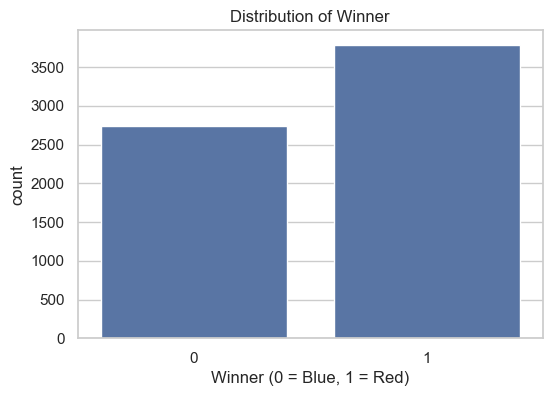

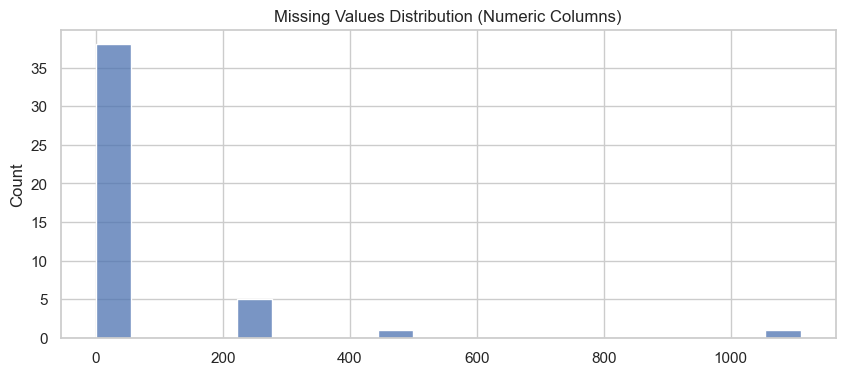


Numeric Summary Stats:



,count,mean,std,min,25%,50%,75%,max
RedFighter,6528.0,819.761795,476.188466,0.0000,419.0000,806.000000,1241.250000,1660.0000
BlueFighter,6528.0,942.707874,556.368724,0.0000,462.0000,922.500000,1427.000000,1921.0000
RedOdds,6301.0,-115.711474,277.225783,-2100.0000,-255.0000,-150.000000,130.000000,775.0000
BlueOdds,6302.0,59.793240,253.117416,-1200.0000,-150.0000,130.000000,215.000000,1300.0000
Winner,6528.0,0.580116,0.493577,0.0000,0.0000,1.000000,1.000000,1.0000
WeightClass,6528.0,5.503370,3.200274,0.0000,3.0000,6.000000,8.000000,12.0000
Gender,6528.0,0.877298,0.328120,0.0000,1.0000,1.000000,1.000000,1.0000
BlueCurrentLoseStreak,6528.0,0.501072,0.794303,0.0000,0.0000,0.000000,1.000000,6.0000
BlueCurrentWinStreak,6528.0,0.957567,1.406786,0.0000,0.0000,0.000000,1.000000,12.0000
BlueDraws,6528.0,0.023131,0.156327,0.0000,0.0000,0.000000,0.000000,2.0000


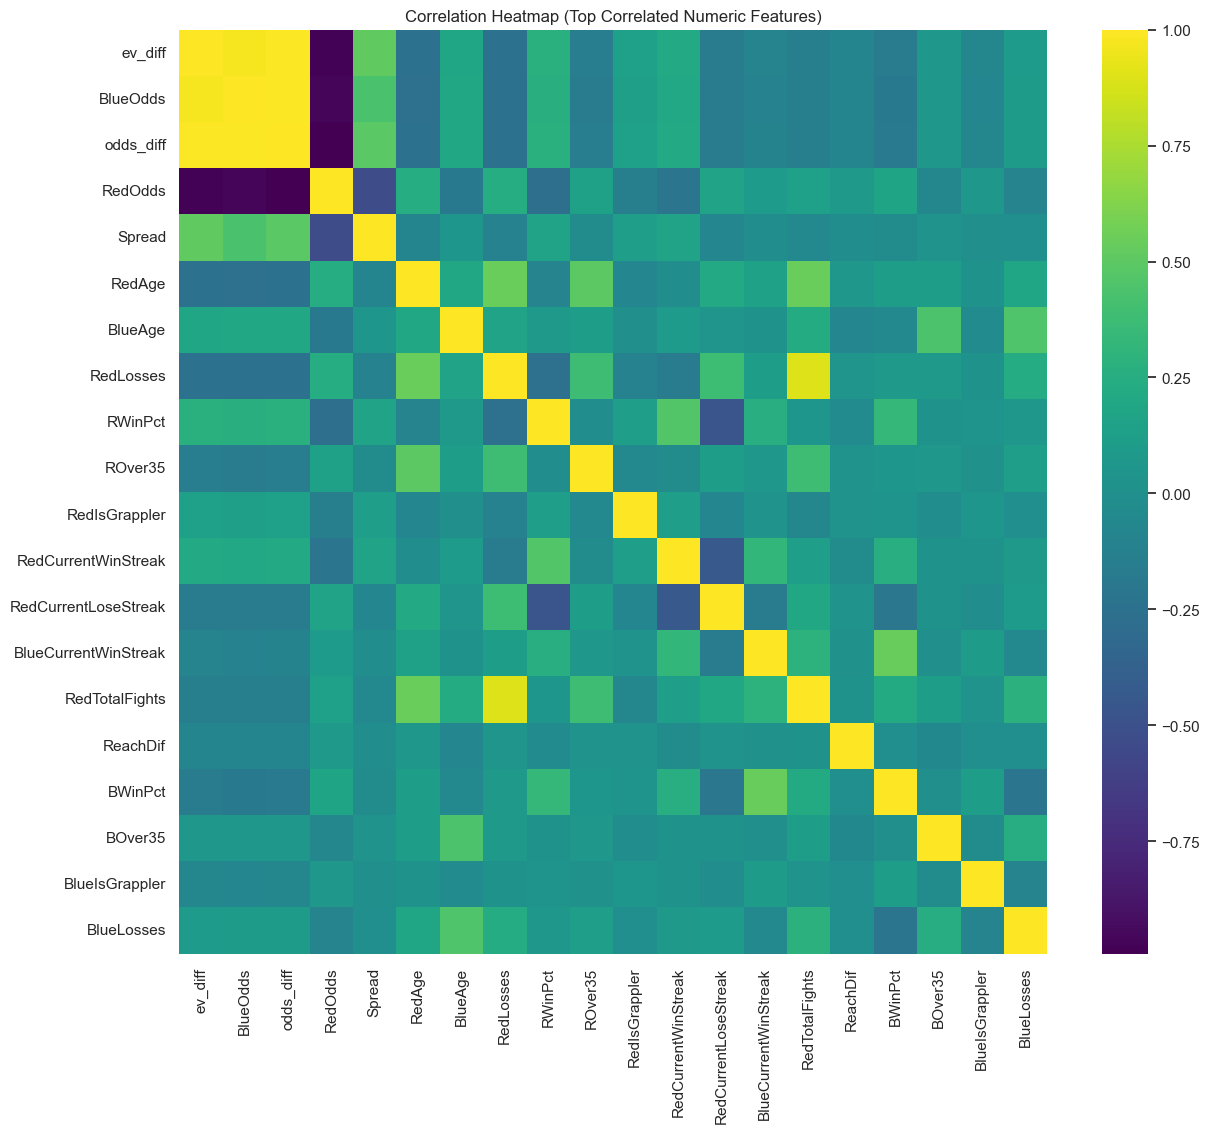

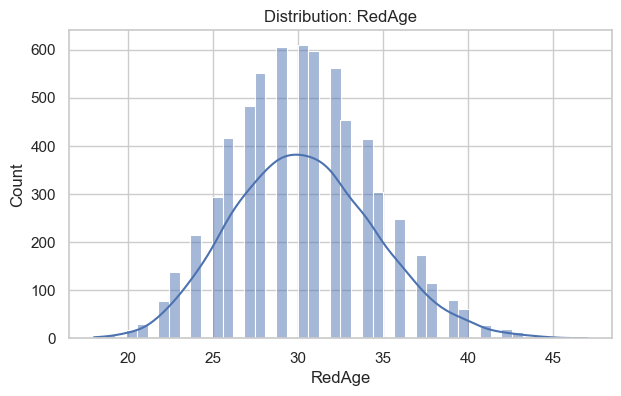

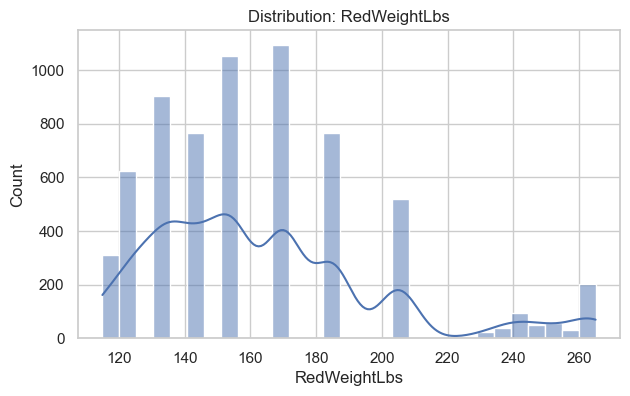

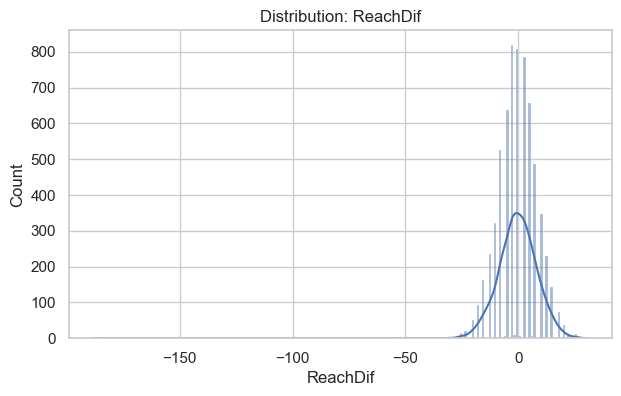

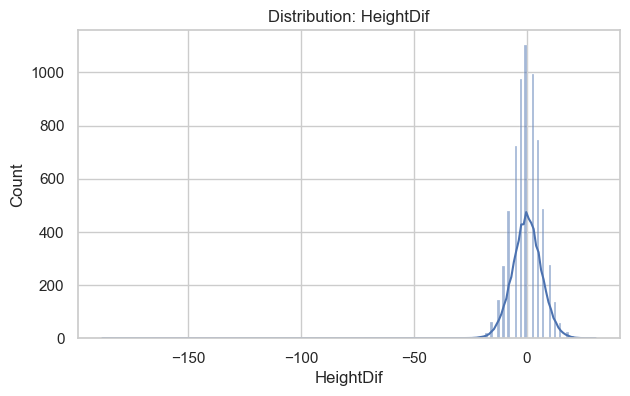

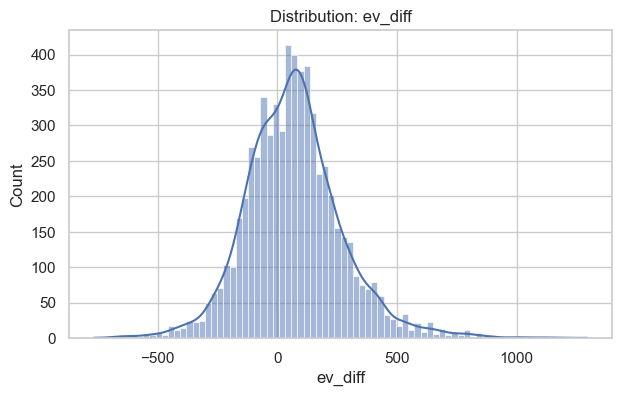

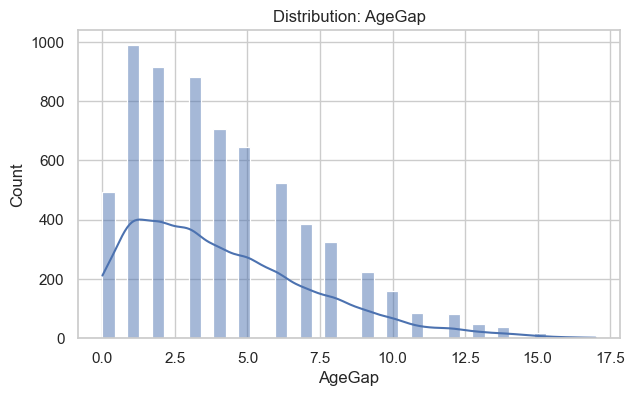

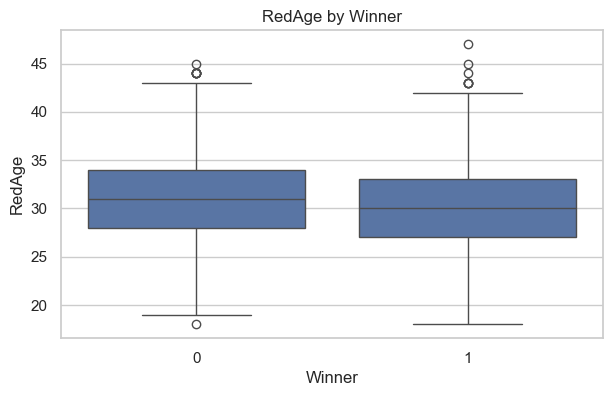

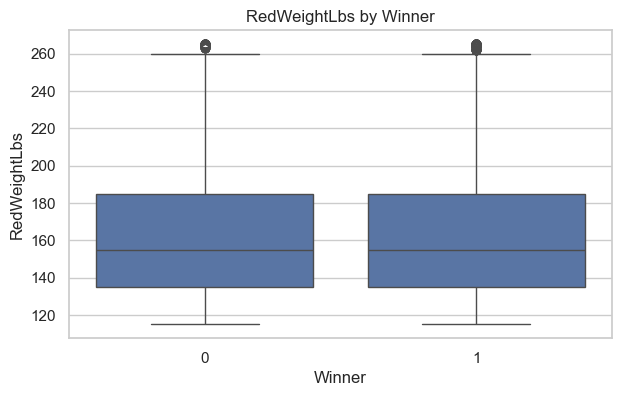

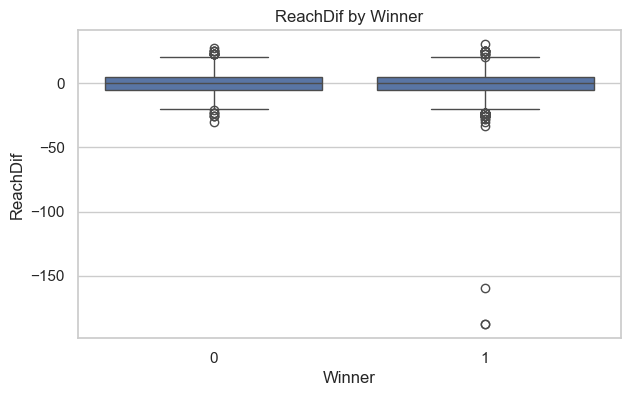

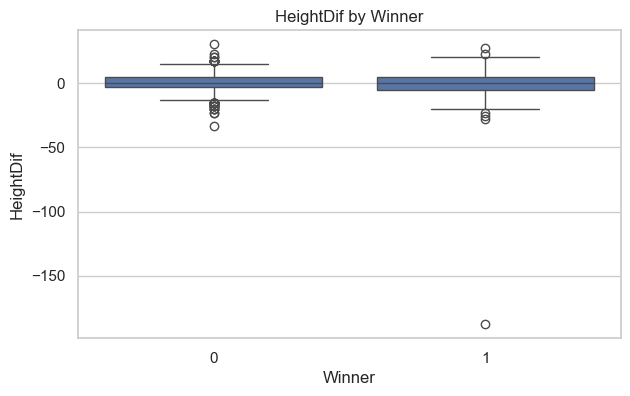

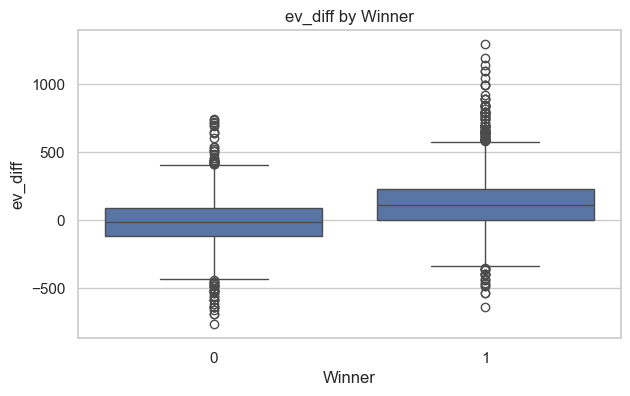

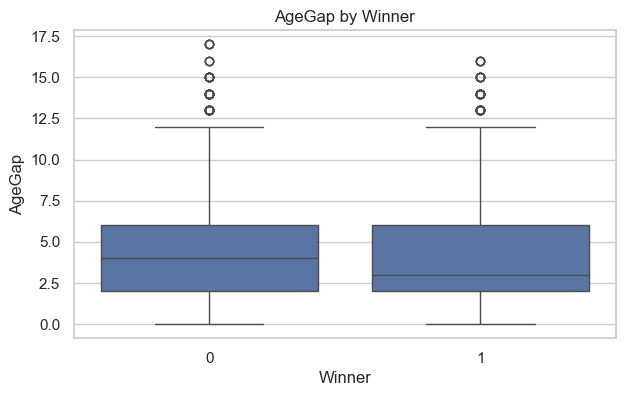

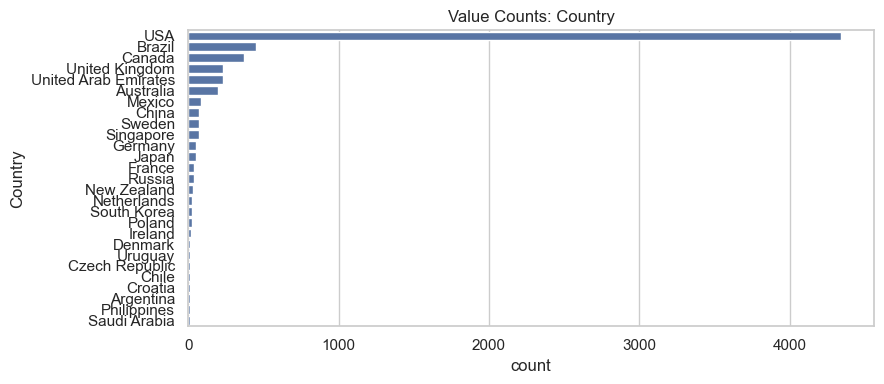

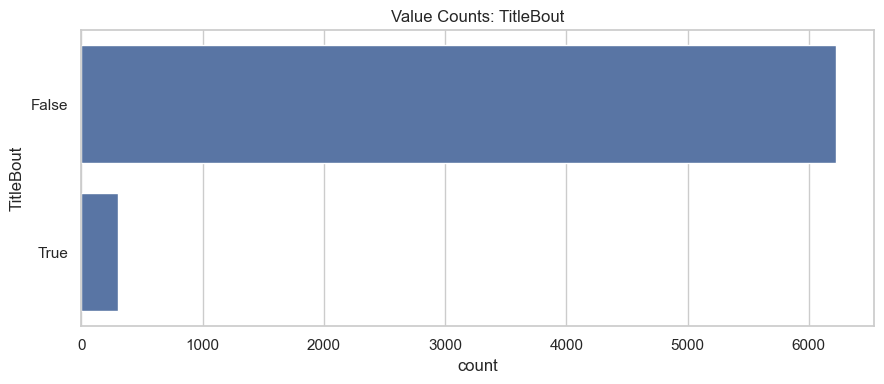

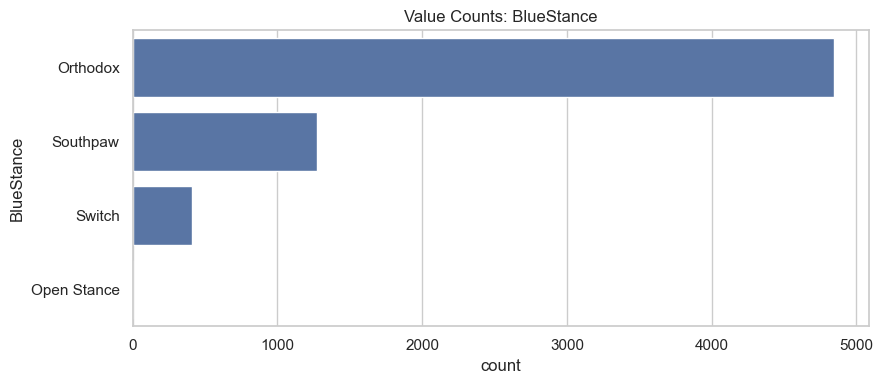

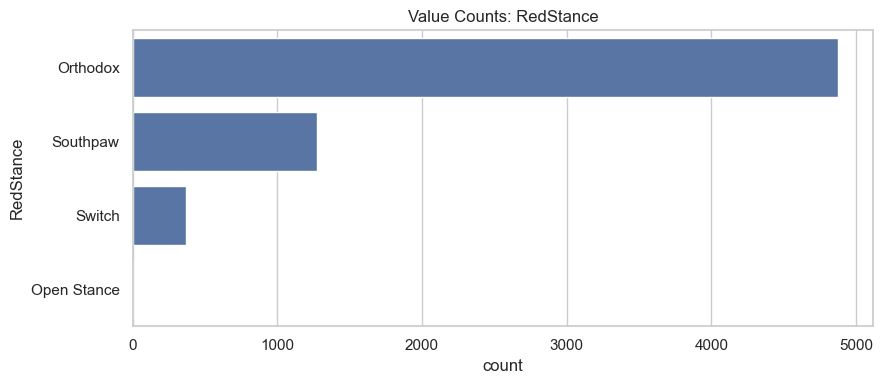

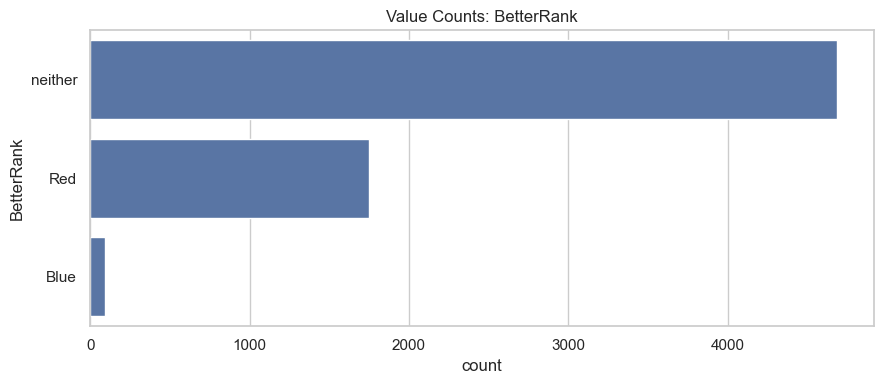

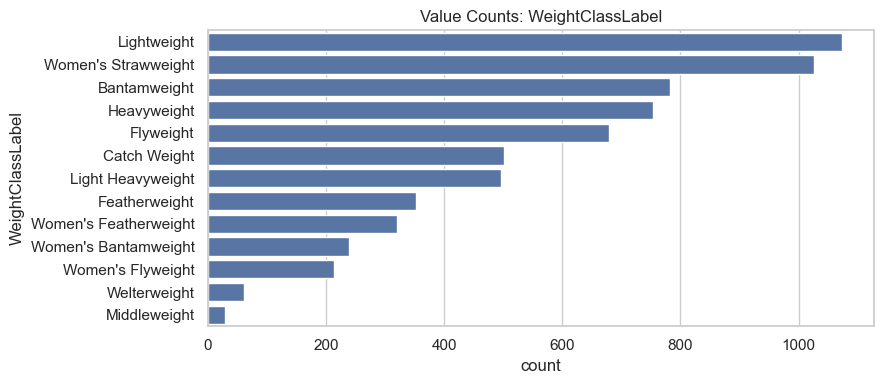

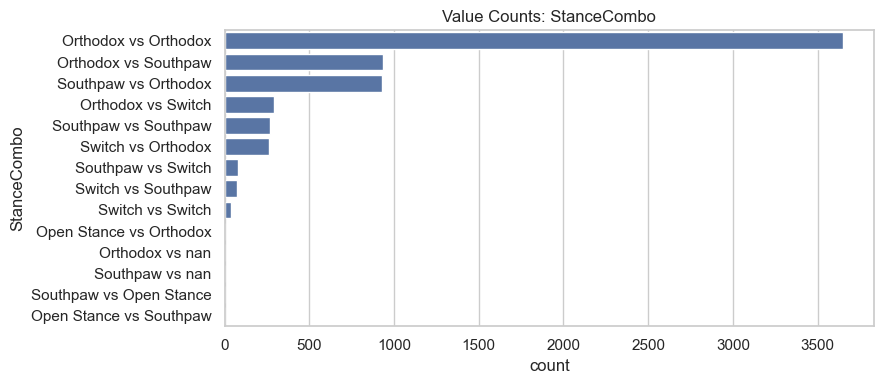

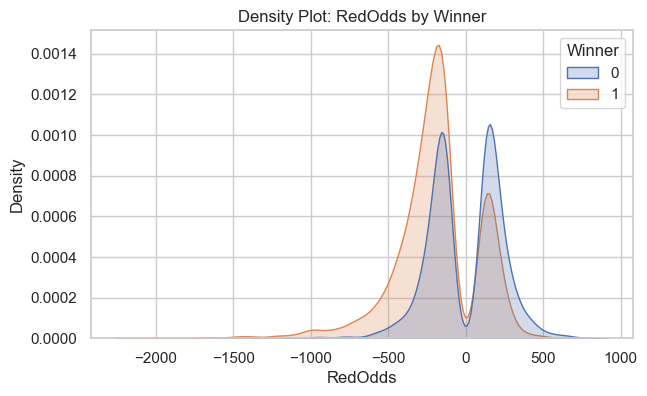

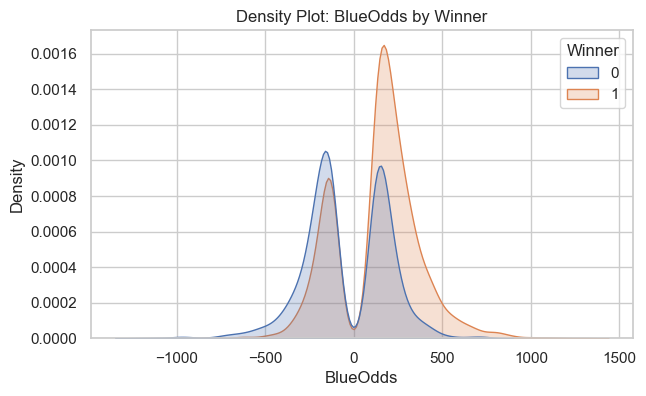


 EDA COMPLETE

Numeric columns: 44
Categorical columns: 7

 Creating matchup-safe split
Train size: (5218, 52)
Test size: (1310, 52)
Unique matchups in train: 5170
Unique matchups in test: 1293

Updated numeric columns: 42
Updated categorical columns: 7

Running MICE-Forest Imputation on numeric columns...
MICE Imputation Completed.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------
# columns with excessive missingness
# ------------------------------------------------
cols_missing = [
    'BMatchWCRank', 'RMatchWCRank', 'RWFlyweightRank', 'RWFeatherweightRank',
    'RWStrawweightRank', 'RWBantamweightRank', 'RHeavyweightRank',
    'RLightHeavyweightRank', 'RMiddleweightRank', 'RWelterweightRank',
    'RLightweightRank', 'RFeatherweightRank', 'RBantamweightRank',
    'RFlyweightRank', 'RPFPRank', 'BWFlyweightRank', 'BWFeatherweightRank',
    'BWStrawweightRank', 'BWBantamweightRank', 'BHeavyweightRank',
    'BLightHeavyweightRank', 'BMiddleweightRank', 'BWelterweightRank',
    'BLightweightRank', 'BFeatherweightRank', 'BBantamweightRank',
    'BFlyweightRank', 'BPFPRank'
]

# ------------------------------------------------
# columns to drop due to data leakage
# ------------------------------------------------
cols_leakage = [
   # Red fighter stats
'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt',
'RedAvgTDLanded', 'RedAvgTDPct', 'RedLongestWinStreak',
'RedTotalRoundsFought', 'RedTotalTitleBouts',
'RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous',
'RedWinsByKO', 'RedWinsBySubmission', 'RedWinsByTKODoctorStoppage',
'RedWins', 'RedStrikingRatio', 'RedStrikingEfficiency', 'RedTDEfficiency',
'RedEffectiveTD', 'RedExpectedValue', 'RedDecOdds', 'RSubOdds', 'RKOOdds',

# Blue fighter stats
'BlueAvgSigStrLanded', 'BlueAvgSigStrPct', 'BlueAvgSubAtt',
'BlueAvgTDLanded', 'BlueAvgTDPct', 'BlueLongestWinStreak',
'BlueTotalRoundsFought', 'BlueTotalTitleBouts',
'BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous',
'BlueWinsByKO', 'BlueWinsBySubmission', 'BlueWinsByTKODoctorStoppage',
'BlueWins', 'BlueStrikingRatio', 'BlueStrikingEfficiency', 'BlueTDEfficiency',
'BlueEffectiveTD', 'BlueExpectedValue', 'BlueDecOdds', 'BSubOdds', 'BKOOdds',

'Finish', 'FinishDetails', 'FinishRound', 'FinishRoundTime', 'TotalFightTimeSecs', 'Favorite', 'FavoriteWins', 'EmptyArena',

# Derived features (may include current fight outcome) 
'SigStrDif', 'AvgSubAttDif', 'AvgTDDif', 'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 
'WinDif', 'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 
'NumberOfRounds', 'EffectiveTDDif', 'draw_diff', 'avg_sig_str_pct_diff', 'avg_TD_pct_diff', 
'win_by_Decision_Majority_diff', 'win_by_Decision_Split_diff', 'win_by_Decision_Unanimous_diff', 'win_by_TKO_Doctor_Stoppage_dif' 


]

df_clean = df.drop(columns=cols_missing + cols_leakage, errors='ignore')

# ---------------------
# Load features + target
# ---------------------
X = df_clean.drop(columns=['Winner'])
y = df_clean['Winner']

print("Raw feature columns:")
print(X.columns.tolist())



print("\nFeatures considered for modeling (Red-only):")
print(X.columns.tolist())


# ===========================================================
#                EXPLORATORY DATA ANALYSIS
# ===========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

print("\n==============================")
print(" BASIC DATA OVERVIEW")
print("==============================")
print(df_clean.head())
print("\nShape:", df_clean.shape)
print("\nData types:\n", df_clean.dtypes)
print("\nMissing values per column:\n", df_clean.isna().sum().sort_values(ascending=False))


# -----------------------------------------------------------
# 1. Target variable distribution
# -----------------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=df_clean['Winner'])
plt.title("Distribution of Winner")
plt.xlabel("Winner (0 = Blue, 1 = Red)")
plt.show()


# -----------------------------------------------------------
# 2. Numeric feature summary
# -----------------------------------------------------------
num_df = df_clean.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(10,4))
sns.histplot(num_df.isna().sum(), bins=20)
plt.title("Missing Values Distribution (Numeric Columns)")
plt.show()

print("\nNumeric Summary Stats:\n")
display(num_df.describe().T)


# -----------------------------------------------------------
# Correlation Heatmap (top 20 strongest correlations)
# -----------------------------------------------------------
plt.figure(figsize=(14,12))
corr = num_df.corr()

# keep strongest correlations with target
if 'Winner' in corr.columns:
    target_corr = corr['Winner'].abs().sort_values(ascending=False)[1:21]
    top_corr_cols = target_corr.index.tolist()
else:
    top_corr_cols = num_df.columns[:20]

sns.heatmap(num_df[top_corr_cols].corr(), annot=False, cmap='viridis')
plt.title("Correlation Heatmap (Top Correlated Numeric Features)")
plt.show()


# -----------------------------------------------------------
# Distribution plots for key variables
# -----------------------------------------------------------

cols_to_plot = [
    'RedAge', 'RedWeightLbs', 'ReachDif', 'HeightDif', 'Oddsdiff',
    'ev_diff', 'AgeGap'
]
cols_to_plot = [c for c in cols_to_plot if c in df_clean.columns]

for col in cols_to_plot:
    plt.figure(figsize=(7,4))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribution: {col}")
    plt.show()


# -----------------------------------------------------------
# Boxplots of numeric variables by Winner
# -----------------------------------------------------------
for col in cols_to_plot:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df_clean["Winner"], y=df_clean[col])
    plt.title(f"{col} by Winner")
    plt.show()


# -----------------------------------------------------------
# Categorical feature frequencies
# -----------------------------------------------------------
cat_df = df_clean.select_dtypes(include=['object','category'])

for col in cat_df.columns:
    plt.figure(figsize=(9,4))
    sns.countplot(y=df_clean[col], order=df_clean[col].value_counts().index)
    plt.title(f"Value Counts: {col}")
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------
# Relationship between odds & outcome 
# -----------------------------------------------------------
odds_cols = [c for c in df_clean.columns if 'Odds' in c]

for col in odds_cols:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=df_clean, x=col, hue="Winner", fill=True)
    plt.title(f"Density Plot: {col} by Winner")
    plt.show()


print("\n==============================")
print(" EDA COMPLETE")
print("==============================")


# ---------------------------------------------------
# Recompute num/cat columns after feature filtering
# ---------------------------------------------------
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

# ---------------------
# Encode target
# ---------------------
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# ===========================================================
#         TRAIN/TEST SPLIT (matchup-safe, no leakage)
# ===========================================================

print("\n==============================")
print(" Creating matchup-safe split")
print("==============================")


# create MatchupID safely (convert values to string)
df_clean["MatchupID"] = df_clean.apply(
    lambda row: "_".join(
        sorted([
            str(row.get("RedFighter", "")),
            str(row.get("BlueFighter", ""))
        ])
    ),
    axis=1
)


# 2. Rebuild X and y including MatchupID
X = df_clean.drop(columns=['Winner'])
y = df_clean['Winner']
y_enc = le.transform(y)    # use your existing encoder

# 3. Perform group-based split
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y_enc, groups=df_clean["MatchupID"]))

X_train = X.iloc[train_idx].reset_index(drop=True)
X_test  = X.iloc[test_idx].reset_index(drop=True)
y_train = y_enc[train_idx]
y_test  = y_enc[test_idx]

print("Train size:", X_train.shape)
print("Test size:",  X_test.shape)
print("Unique matchups in train:", df_clean.iloc[train_idx]["MatchupID"].nunique())
print("Unique matchups in test:",  df_clean.iloc[test_idx]["MatchupID"].nunique())

# 4. Remove identity columns not allowed in modeling
drop_cols = ["RedFighter", "BlueFighter", "MatchupID"]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

groups_train = df_clean.iloc[train_idx]["MatchupID"].values


# ===========================================================
#   RECOMPUTE NUMERIC COLUMNS AFTER FINAL FEATURE SELECTION
# ===========================================================
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("\nUpdated numeric columns:", len(num_cols))
print("Updated categorical columns:", len(cat_cols))

# ===============================================================
#  MICEFOREST IMPUTATION (numeric columns only)
# ===============================================================
import miceforest as mf

print("\nRunning MICE-Forest Imputation on numeric columns...")

# Reset index and ensure numeric columns only
X_train_num = X_train[num_cols].reset_index(drop=True)
X_test_num = X_test[num_cols].reset_index(drop=True)

# Ensure column names are strings (required by miceforest)
X_train_num.columns = X_train_num.columns.astype(str)
X_test_num.columns = X_test_num.columns.astype(str)

# Combine train + test numeric columns
X_full_num = pd.concat([X_train_num, X_test_num], axis=0).reset_index(drop=True)

# Build kernel
kernel = mf.ImputationKernel(
    data=X_full_num,
    num_datasets=1,
    variable_schema=None,
    random_state=42,
    save_all_iterations_data=False
)

# Run MICE
kernel.mice(
    iterations=3,
    n_estimators=50
)

# Extract completed numeric data
X_full_num_completed = kernel.complete_data(dataset=0)

# Split back into train/test
X_train[num_cols] = X_full_num_completed.iloc[:len(X_train)].values
X_test[num_cols] = X_full_num_completed.iloc[len(X_train):].values

print("MICE Imputation Completed.\n")


# ----------------------------
# Preprocessing pipeline
# ----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer  # still needed for categorical

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # numeric already imputed
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

#'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt', 'RedAvgTDLanded', 'RedAvgTDPct', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif', 'EmptyArena',  'RedTotalRoundsFought', 'RedTotalTitleBouts', 'RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous', 'RedWinsByKO', 'RedWinsBySubmission', 'RedWinsByTKODoctorStoppage', 'RedWins', 'Finish','RedStrikingRatio'  'RedStrikingEfficiency', 'RedTDEfficiency', 'RedEffectiveTD', 'EffectiveTDDif','FinishDetails', 'FinishRound', 'FinishRoundTime', 'TotalFightTimeSecs',


Training LogisticRegression
Random State 1
Best Params: {'classifier__C': 0.1}
Validation Accuracy (CV): 0.6579
Test Accuracy: 0.6573

Random State 2
Best Params: {'classifier__C': 0.1}
Validation Accuracy (CV): 0.6579
Test Accuracy: 0.6573

Random State 3
Best Params: {'classifier__C': 0.1}
Validation Accuracy (CV): 0.6579
Test Accuracy: 0.6573

Average Test Accuracy for LogisticRegression: 0.6573

Training RandomForest
Random State 1
Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Validation Accuracy (CV): 0.6577
Test Accuracy: 0.6527

Random State 2
Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Validation Accuracy (CV): 0.6577
Test Accuracy: 0.6527

Random State 3
Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Validation Accuracy (CV): 0.6577
Test Accuracy: 0.6527

Average Test Accuracy for

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:

Best Params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Validation Accuracy (CV): 0.6598
Test Accuracy: 0.6557

Random State 2


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:

Best Params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Validation Accuracy (CV): 0.6598
Test Accuracy: 0.6557

Random State 3


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:36:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:

Best Params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Validation Accuracy (CV): 0.6598
Test Accuracy: 0.6557

Average Test Accuracy for XGBoost: 0.6557


       FINAL RESULTS TABLE

           Algorithms                                         Parameters  \
0  LogisticRegression                             {'classifier__C': 0.1}   
1        RandomForest  {'classifier__max_depth': 10, 'classifier__min...   
2                 SVM  {'classifier__C': 0.1, 'classifier__kernel': '...   
3             XGBoost  {'classifier__learning_rate': 0.01, 'classifie...   

   Mean test score  Standard deviation  Best model validation score  \
0           0.6573                 0.0                       0.6573   
1           0.6527                 0.0                       0.6527   
2           0.6580                 0.0                       0.6580   
3           0.6557                 0.0                       0.6557   

   Test score  
0      0.

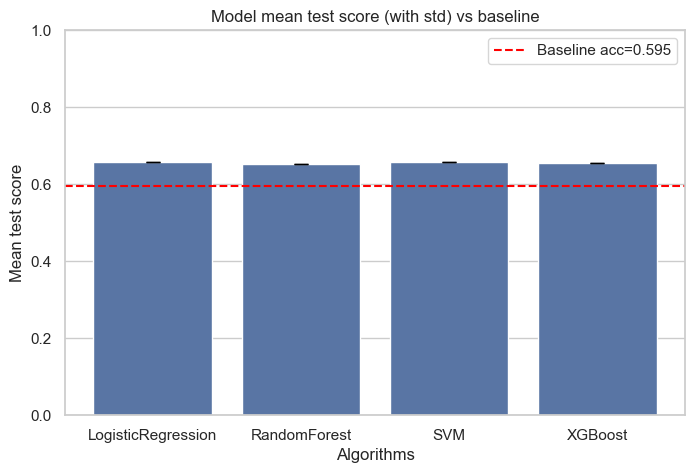

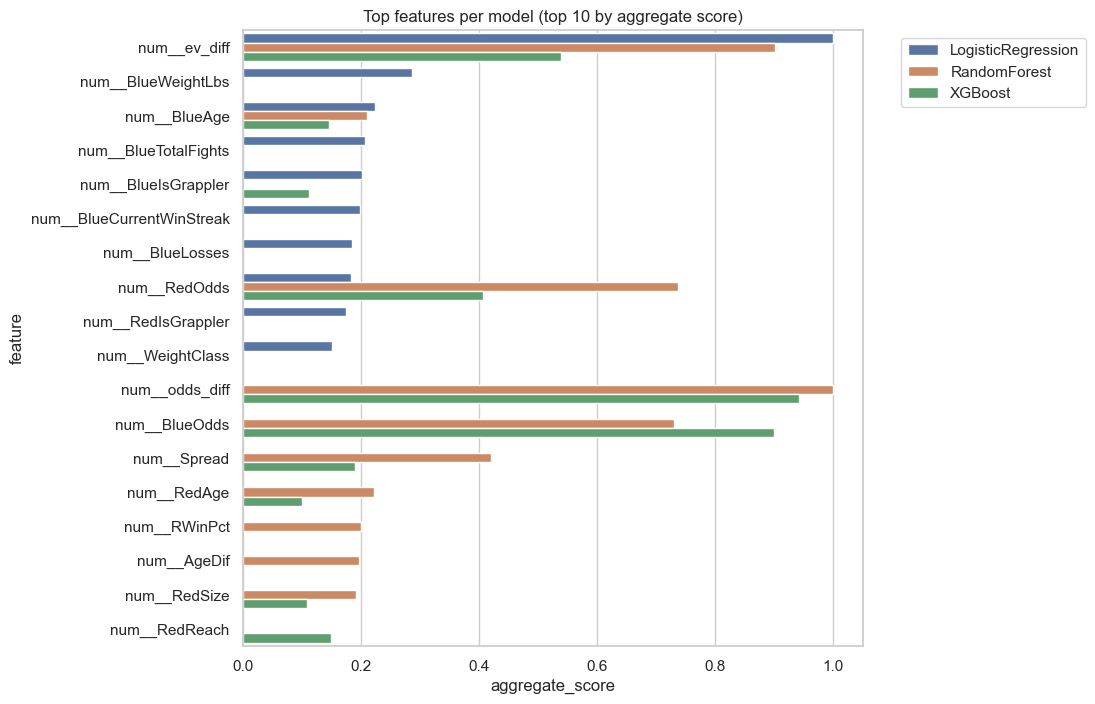



=== Suggested Discussion Points ===
- Baseline accuracy (majority class): 0.595
- Compare each model's mean test score to baseline; compute z-scores above baseline (table column 'Z_score_above_baseline').
- Models with positive z-scores are performing better than baseline beyond the spread across random states.
- Use permutation importance + SHAP mean-abs + (impurity if available) to triangulate which features are truly predictive.
- Local SHAP outputs are stored in the 'local_shap_example' column of the performance table; examine individual instances to understand model decisions.
- Unexpected/interesting findings should point to features that are consistently high across all three importance measures or features that differ between models.


 FINAL ANALYSIS: LogisticRegression
Transformed columns: ['num__RedOdds' 'num__BlueOdds' 'num__WeightClass' 'num__Gender'
 'num__BlueCurrentLoseStreak' 'num__BlueCurrentWinStreak' 'num__BlueDraws'
 'num__BlueLosses' 'num__BlueWeightLbs' 'num__R

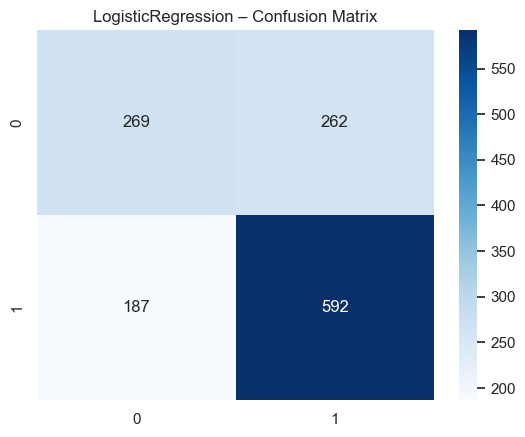

LogisticRegression AUROC: 0.7035
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       531
           1       0.69      0.76      0.73       779

    accuracy                           0.66      1310
   macro avg       0.64      0.63      0.64      1310
weighted avg       0.65      0.66      0.65      1310

SHAP failed for LogisticRegression: Unknown type passed as data object: <class 'shap.maskers._tabular.Independent'>


 FINAL ANALYSIS: RandomForest
Transformed columns: ['num__RedOdds' 'num__BlueOdds' 'num__WeightClass' 'num__Gender'
 'num__BlueCurrentLoseStreak' 'num__BlueCurrentWinStreak' 'num__BlueDraws'
 'num__BlueLosses' 'num__BlueWeightLbs' 'num__RedCurrentLoseStreak'
 'num__RedCurrentWinStreak' 'num__RedDraws' 'num__RedLosses'
 'num__RedWeightLbs' 'num__RedAge' 'num__BlueAge' 'num__HeightDif'
 'num__ReachDif' 'num__AgeDif' 'num__BlueHeight' 'num__BlueReach'
 'num__RedHeight' 'num__RedReach' 'num__ROver35' 'num__BOver35'
 'num

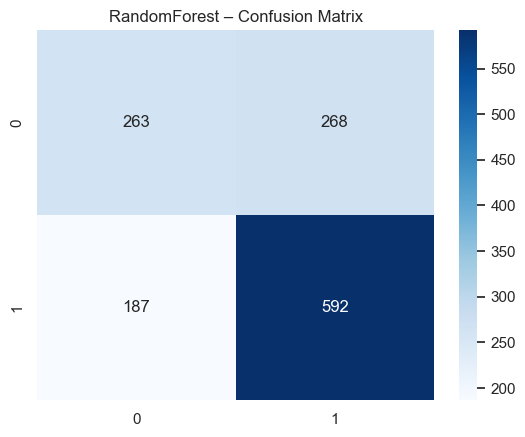

RandomForest AUROC: 0.6922
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       531
           1       0.69      0.76      0.72       779

    accuracy                           0.65      1310
   macro avg       0.64      0.63      0.63      1310
weighted avg       0.65      0.65      0.65      1310



<Figure size 640x480 with 0 Axes>

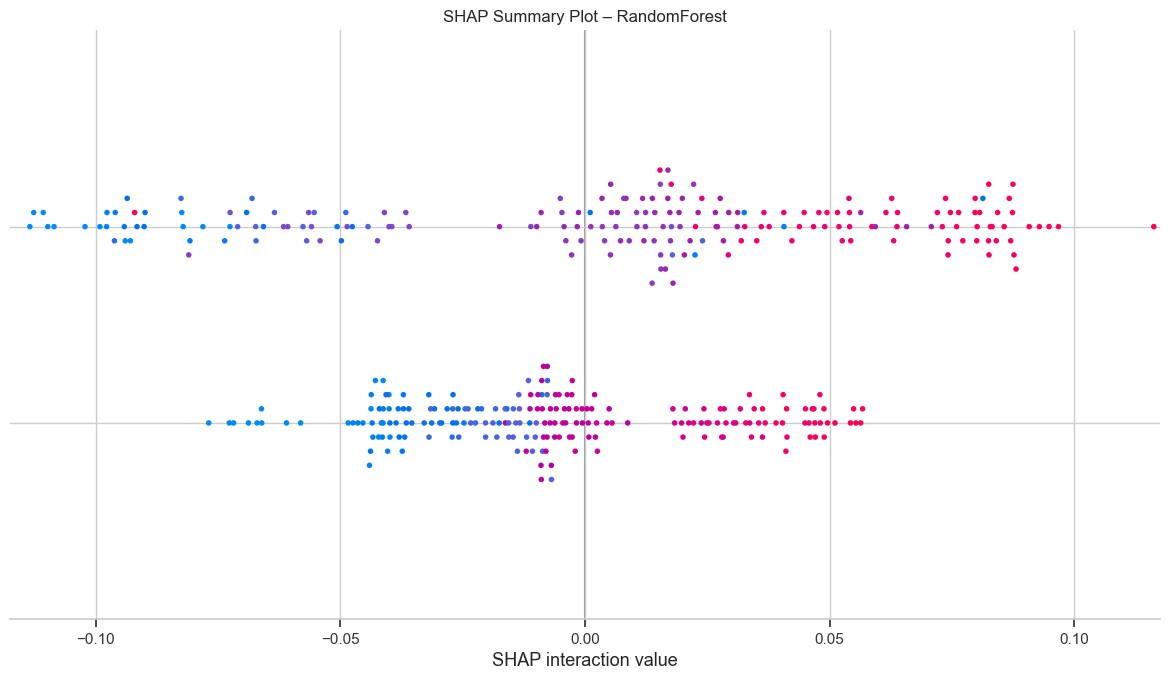



 FINAL ANALYSIS: SVM
Transformed columns: ['num__RedOdds' 'num__BlueOdds' 'num__WeightClass' 'num__Gender'
 'num__BlueCurrentLoseStreak' 'num__BlueCurrentWinStreak' 'num__BlueDraws'
 'num__BlueLosses' 'num__BlueWeightLbs' 'num__RedCurrentLoseStreak'
 'num__RedCurrentWinStreak' 'num__RedDraws' 'num__RedLosses'
 'num__RedWeightLbs' 'num__RedAge' 'num__BlueAge' 'num__HeightDif'
 'num__ReachDif' 'num__AgeDif' 'num__BlueHeight' 'num__BlueReach'
 'num__RedHeight' 'num__RedReach' 'num__ROver35' 'num__BOver35'
 'num__RWinPct' 'num__BWinPct' 'num__RedTotalFights'
 'num__BlueTotalFights' 'num__RedIsGrappler' 'num__BlueIsGrappler'
 'num__RedIsStriker' 'num__BlueIsStriker' 'num__RGrapplerVBStriker'
 'num__BGrapplerVRStriker' 'num__RedSize' 'num__BlueSize'
 'num__win_by_TKO_Doctor_Stoppage_diff' 'num__odds_diff' 'num__ev_diff'
 'num__AgeGap' 'num__Spread' 'cat__Country_Argentina'
 'cat__Country_Australia' 'cat__Country_Brazil' 'cat__Country_Canada'
 'cat__Country_Chile' 'cat__Country_China' 'cat_

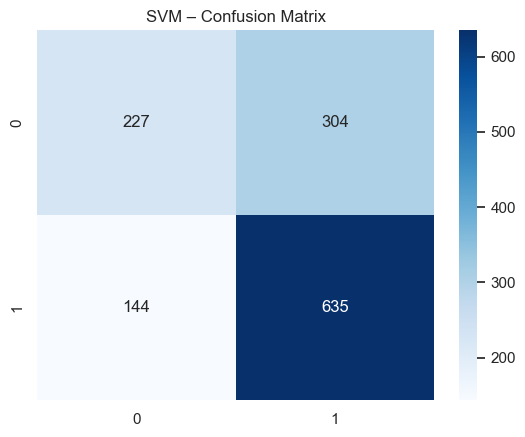

SVM AUROC: 0.6938
              precision    recall  f1-score   support

           0       0.61      0.43      0.50       531
           1       0.68      0.82      0.74       779

    accuracy                           0.66      1310
   macro avg       0.64      0.62      0.62      1310
weighted avg       0.65      0.66      0.64      1310

SVM does not support feature importances.
Skipping SHAP for SVM — SHAP KernelExplainer is too slow for SVM models.


 FINAL ANALYSIS: XGBoost
Transformed columns: ['num__RedOdds' 'num__BlueOdds' 'num__WeightClass' 'num__Gender'
 'num__BlueCurrentLoseStreak' 'num__BlueCurrentWinStreak' 'num__BlueDraws'
 'num__BlueLosses' 'num__BlueWeightLbs' 'num__RedCurrentLoseStreak'
 'num__RedCurrentWinStreak' 'num__RedDraws' 'num__RedLosses'
 'num__RedWeightLbs' 'num__RedAge' 'num__BlueAge' 'num__HeightDif'
 'num__ReachDif' 'num__AgeDif' 'num__BlueHeight' 'num__BlueReach'
 'num__RedHeight' 'num__RedReach' 'num__ROver35' 'num__BOver35'
 'num__RWinPct' 'num__BWin

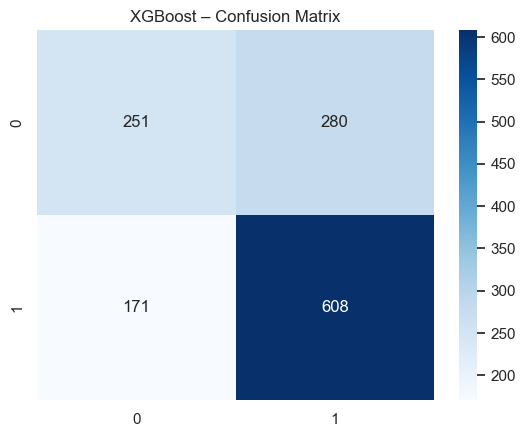

XGBoost AUROC: 0.6931
              precision    recall  f1-score   support

           0       0.59      0.47      0.53       531
           1       0.68      0.78      0.73       779

    accuracy                           0.66      1310
   macro avg       0.64      0.63      0.63      1310
weighted avg       0.65      0.66      0.65      1310



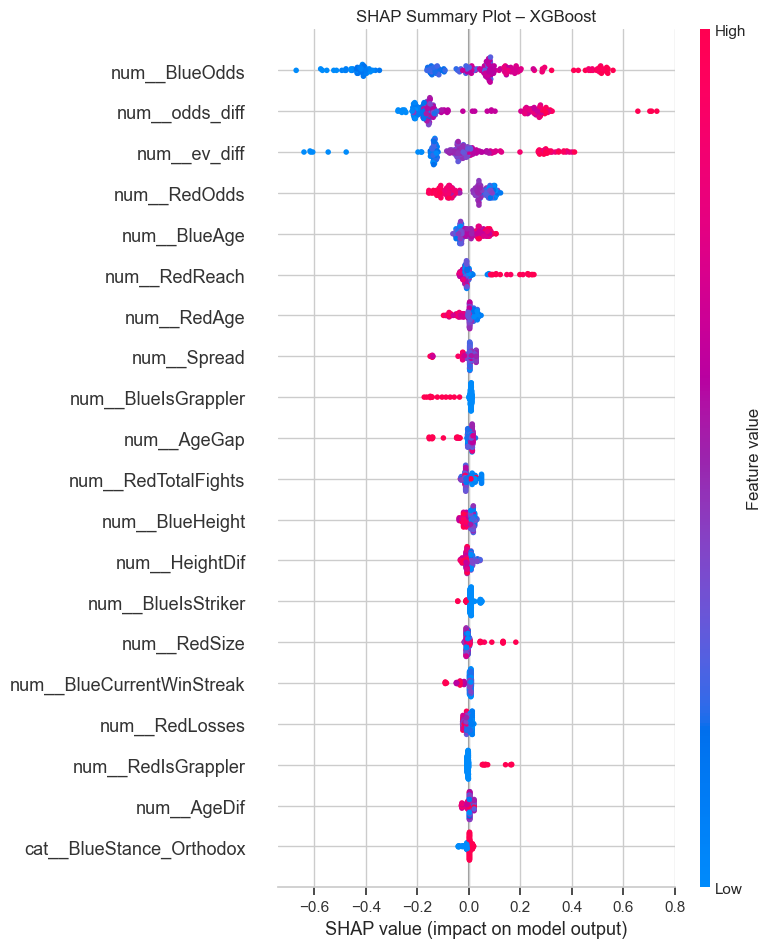

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split, GridSearchCV, KFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold


# ==============================================
#  Machine Learning Pipelines
# ==============================================
pipelines = {
    'LogisticRegression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),

    'RandomForest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),

    'SVM': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True))
    ]),

    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}


# ==============================================
#  Hyperparameter Grids
# ==============================================
param_grids = {
    'LogisticRegression': {'classifier__C': [0.01, 0.1, 1, 10]},
    
    'RandomForest': {
        'classifier__n_estimators': [100, 300],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },

    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', 'linear']
    },

    'XGBoost': {
        'classifier__n_estimators': [100, 300],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

nr_states = 3
kf_splits = 5
results_summary = {}

#  model training loop 
for name, pipeline_model in pipelines.items():
    print(f"\n======================")
    print(f"Training {name}")
    print(f"======================")

    test_scores = []
    best_param_list = []
    final_models = []

    for i in range(nr_states):
        print(f"Random State {i+1}")

        cv = GroupKFold(n_splits=kf_splits)

        grid = GridSearchCV(
            pipeline_model,
            param_grid=param_grids[name],
            scoring='accuracy',
            cv=cv,
            n_jobs=-1
        )

        grid.fit(X_train, y_train, groups=groups_train)

        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_param_list.append(best_params)
        final_models.append(best_model)

        y_test_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_test_pred)
        test_scores.append(acc)

        print(f"Best Params: {best_params}")
        print(f"Validation Accuracy (CV): {grid.best_score_:.4f}")
        print(f"Test Accuracy: {acc:.4f}\n")

    avg_test_score = np.mean(test_scores)
    print(f"Average Test Accuracy for {name}: {avg_test_score:.4f}")

    results_summary[name] = {
        'test_scores': test_scores,
        'avg_test_score': avg_test_score,
        'best_params': best_param_list,
        'models': final_models
    }

# results table based on rubric 
table_rows = []

for model_name, info in results_summary.items():

    # Best val score is the highest CV accuracy across random states
    best_val_score = max([
        max_state for max_state in info['test_scores']
    ])

    # Best parameter set (use the one from random state 0)
    best_params = info["best_params"][0]

    # Mean test score across random states
    mean_test_score = np.mean(info["test_scores"])

    # sd
    std_test_score = np.std(info["test_scores"])

    # Best model for test score (random state 0)
    best_model = info["models"][0]

    table_rows.append({
        "Algorithms": model_name,
        "Parameters": best_params,
        "Mean test score": round(mean_test_score, 4),
        "Standard deviation": round(std_test_score, 4),
        "Best model validation score": round(best_val_score, 4),
        "Test score": round(info["avg_test_score"], 4)
    })

results_table = pd.DataFrame(table_rows)

print("\n\n===============================")
print("       FINAL RESULTS TABLE")
print("===============================\n")
print(results_table)

# more results from examples 
import numpy as np
import shap
from sklearn.metrics import accuracy_score, fbeta_score, f1_score, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns


# fit a copy of the preprocessor on training data so we can extract names and transformed arrays
fitted_preprocessor = preprocessor.fit(X_train)

try:
    feature_names = fitted_preprocessor.get_feature_names_out()
except Exception:
    feature_names = X_train.columns.tolist()

X_train_trans = fitted_preprocessor.transform(X_train)
X_test_trans  = fitted_preprocessor.transform(X_test)

# if transforms produce sparse matrix, make dense for some operations (SHAP/permutation)
if hasattr(X_train_trans, "toarray"):
    X_train_dense = X_train_trans.toarray()
    X_test_dense  = X_test_trans.toarray()
else:
    X_train_dense = np.asarray(X_train_trans)
    X_test_dense  = np.asarray(X_test_trans)

# ---------------------------
# baselines: majority-class predictions
# ---------------------------
# find majority label in training set
(unique, counts) = np.unique(y_train, return_counts=True)
majority_label = unique[np.argmax(counts)]
baseline_preds = np.full_like(y_test, fill_value=majority_label)

baseline_acc = accuracy_score(y_test, baseline_preds)
# macro F-beta (bc works multi-class or binary)
baseline_f05 = fbeta_score(y_test, baseline_preds, beta=0.5, average='macro', zero_division=0)
baseline_f1  = f1_score(y_test, baseline_preds, average='macro', zero_division=0)
baseline_f2  = fbeta_score(y_test, baseline_preds, beta=2, average='macro', zero_division=0)

print("\n=== Baseline (majority class) ===")
print(f"Majority label: {majority_label}")
print(f"Baseline accuracy: {baseline_acc:.4f}")
print(f"Baseline F0.5 (macro): {baseline_f05:.4f}")
print(f"Baseline F1 (macro): {baseline_f1:.4f}")
print(f"Baseline F2 (macro): {baseline_f2:.4f}")

# ---------------------------
# compare models to baseline; compute permutation + impurity + SHAP importances 
# ---------------------------
summary_rows = []
global_importances_all = []  

for model_name, info in results_summary.items():
    print(f"\n\n===== ANALYZING {model_name} =====")

    # best pipeline/model: using model at index 0 (the model stored per random state)
    pipeline_best = info['models'][0]
    classifier = pipeline_best.named_steps['classifier']

    # pred + basic metrics on test set
    y_test_pred = pipeline_best.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    f05 = fbeta_score(y_test, y_test_pred, beta=0.5, average='macro', zero_division=0)
    f1  = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    f2  = fbeta_score(y_test, y_test_pred, beta=2, average='macro', zero_division=0)

    # Mean and std of test scores across random states (already stored as avg_test_score and test_scores)
    mean_test = info.get('avg_test_score', np.mean(info['test_scores']))
    std_test  = np.std(info['test_scores']) if 'test_scores' in info else np.nan

    # of std dev above baseline accuracy (if std != 0)
    if std_test and std_test > 0:
        z_score = (mean_test - baseline_acc) / std_test
    else:
        z_score = np.nan

    print(f"Mean CV/Test (avg across states): {mean_test:.4f}  (std across states: {std_test:.4f})")
    print(f"Test accuracy (best model): {acc:.4f}")
    print(f"F0.5/F1/F2 (test): {f05:.4f} / {f1:.4f} / {f2:.4f}")
    print(f"Z-score above baseline accuracy: {z_score if not np.isnan(z_score) else 'N/A'}")

    # ---------------------------
    # impurity importance (tree-based only)
    # ---------------------------
    impurity_df = None
    if hasattr(classifier, "feature_importances_"):
        try:
            imp = classifier.feature_importances_
            impurity_df = pd.DataFrame({
                "feature": feature_names,
                "impurity_importance": imp
            }).sort_values("impurity_importance", ascending=False)
            print("Impurity importance computed.")
        except Exception as e:
            print("Impurity importance failed:", e)

    # ---------------------------
    # permutation importance (model-agnostic)
    # ---------------------------
    perm_df = None
    try:
        perm = permutation_importance(
            pipeline_best, X_test, y_test,
            n_repeats=20, random_state=42, n_jobs=-1, scoring='accuracy'
        )
        perm_df = pd.DataFrame({
            "feature": feature_names,
            "perm_mean": perm.importances_mean,
            "perm_std": perm.importances_std
        }).sort_values("perm_mean", ascending=False)
        print("Permutation importance computed.")
    except Exception as e:
        print("Permutation importance failed:", e)

    # ---------------------------
    # SHAP global importance (mean absolute SHAP)
    # ---------------------------
    shap_df = None
    try:
        clf_for_shap = classifier
        X_shap_background = X_train_dense[:200] if X_train_dense.shape[0] > 200 else X_train_dense
        # choose explainer automatically (TreeExplainer or LinearExplainer or default)
        explainer = shap.Explainer(clf_for_shap, X_shap_background, feature_names=feature_names)
        shap_values = explainer(X_train_dense[:500])  # compute on subset to save time
        # shap_values.values shape could be (n_samples, n_features) or list (n_classes,...)
        vals = shap_values.values
        if isinstance(vals, list) or (hasattr(vals, "dtype") and vals.dtype == 'object'):
            # for classification multiclass shap returns a list per class; average absolute across classes
            arrs = [np.abs(v).mean(axis=0) for v in vals]
            mean_abs_shap = np.mean(arrs, axis=0)
        else:
            mean_abs_shap = np.abs(vals).mean(axis=0)
        shap_df = pd.DataFrame({
            "feature": feature_names,
            "shap_mean_abs": mean_abs_shap
        }).sort_values("shap_mean_abs", ascending=False)
        print("SHAP global importance computed.")
    except Exception as e:
        print("SHAP global importances failed:", e)

    # ---------------------------
    # combine importances into a single df for easier comparison 
    # ---------------------------
    imp_combined = pd.DataFrame({"feature": feature_names})
    if impurity_df is not None:
        imp_combined = imp_combined.merge(impurity_df, on="feature", how="left")
    if perm_df is not None:
        imp_combined = imp_combined.merge(perm_df[['feature','perm_mean']], on="feature", how="left")
    if shap_df is not None:
        imp_combined = imp_combined.merge(shap_df, on="feature", how="left")

    # normalize columns for ranking (0-1) -> so different measures are comparable
    for col in ['impurity_importance', 'perm_mean', 'shap_mean_abs']:
        if col in imp_combined.columns:
            col_vals = imp_combined[col].fillna(0).values
            if col_vals.max() > 0:
                imp_combined[col + "_norm"] = col_vals / col_vals.max()
            else:
                imp_combined[col + "_norm"] = 0.0

    # compute a simple aggregated score 
    norm_cols = [c for c in imp_combined.columns if c.endswith("_norm")]
    if len(norm_cols) > 0:
        imp_combined['aggregate_score'] = imp_combined[norm_cols].mean(axis=1)
        imp_combined = imp_combined.sort_values('aggregate_score', ascending=False)

    global_importances_all.append((model_name, imp_combined))

    # ---------------------------
    # local SHAP: 3 representative test instances
    # ---------------------------
    local_shap_out = None
    try:
        # compute SHAP values for some test rows
        n_local = min(3, X_test_dense.shape[0])
        if shap_df is not None:
            local_shap = explainer(X_test_dense[:n_local])
            # package local explanations
            local_shap_out = {
                "instance_indices": list(range(n_local)),
                "local_values": local_shap.values,
                "expected_value": local_shap.base_values
            }
            print(f"Computed local SHAP for {n_local} test samples.")
    except Exception as e:
        print("Local SHAP failed:", e)

    # ---------------------------
    # save summary info for table - report 
    # ---------------------------
    summary_rows.append({
        "Algorithms": model_name,
        "Best parameters (example)": info["best_params"][0] if info["best_params"] else None,
        "Mean test score": round(mean_test, 4),
        "Std test score": round(std_test, 4) if not np.isnan(std_test) else None,
        "Test accuracy (best model)": round(acc, 4),
        "Test F0.5": round(f05, 4),
        "Test F1": round(f1, 4),
        "Test F2": round(f2, 4),
        "Z_score_above_baseline": round(z_score, 4) if not np.isnan(z_score) else None,
        "Top feature (aggregate)": imp_combined['feature'].iloc[0] if 'aggregate_score' in imp_combined.columns and not imp_combined.empty else None,
        "Least feature (aggregate)": imp_combined['feature'].iloc[-1] if 'aggregate_score' in imp_combined.columns and not imp_combined.empty else None,
        "local_shap_example": local_shap_out
    })

# ---------------------------
# df summarizing everything
# ---------------------------
model_perf_df = pd.DataFrame(summary_rows)
print("\n\n=== Model performance summary vs baseline ===")
print(model_perf_df)

# ---------------------------
# barplot of mean test score with error bars
# ---------------------------
plt.figure(figsize=(8,5))
sns.barplot(data=model_perf_df, x='Algorithms', y='Mean test score', ci=None)
# add error bars manually
for i, row in model_perf_df.iterrows():
    if pd.notnull(row['Std test score']):
        plt.errorbar(i, row['Mean test score'], yerr=row['Std test score'], fmt='none', capsize=5, color='black')
plt.axhline(baseline_acc, color='red', linestyle='--', label=f'Baseline acc={baseline_acc:.3f}')
plt.ylim(0,1)
plt.title("Model mean test score (with std) vs baseline")
plt.legend()
plt.show()

# ---------------------------
# top features across models (aggregate)
# ---------------------------
# top 10 features per model into a single display
top_list = []
for model_name, imp_df in global_importances_all:
    if 'aggregate_score' in imp_df.columns:
        top_feats = imp_df.nlargest(10, 'aggregate_score')[['feature','aggregate_score']].assign(model=model_name)
        top_list.append(top_feats)
    else:
        # fallback to shap or perm
        if 'shap_mean_abs' in imp_df.columns:
            top_feats = imp_df.nlargest(10, 'shap_mean_abs')[['feature','shap_mean_abs']].assign(model=model_name)
            top_list.append(top_feats.rename(columns={'shap_mean_abs':'aggregate_score'}))
if len(top_list)>0:
    top_feats_all = pd.concat(top_list)
    plt.figure(figsize=(8,8))
    sns.barplot(data=top_feats_all, x='aggregate_score', y='feature', hue='model')
    plt.title("Top features per model (top 10 by aggregate score)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.show()
else:
    print("No feature importance data available to plot.")

# ---------------------------
# notes so i don't forget
# ---------------------------
# print("\n\n=== Suggested Discussion Points ===")
# print("- Baseline accuracy (majority class): {:.3f}".format(baseline_acc))
# print("- Compare each model's mean test score to baseline; compute z-scores above baseline (table column 'Z_score_above_baseline').")
# print("- Models with positive z-scores are performing better than baseline beyond the spread across random states.")
# print("- Use permutation importance + SHAP mean-abs + (impurity if available) to triangulate which features are truly predictive.")
# print("- Local SHAP outputs are stored in the 'local_shap_example' column of the performance table; examine individual instances to understand model decisions.")
# print("- Unexpected/interesting findings should point to features that are consistently high across all three importance measures or features that differ between models.")


# ===========================================================
#  FIX SHAP INPUTS (DENSE REQUIRED FOR TREE MODELS)
# ===========================================================
X_train_dense = X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
X_test_dense  = X_test_transformed.toarray()  if hasattr(X_test_transformed, "toarray")  else X_test_transformed

# ===========================================================
#  SHAP FUNCTION (Robust across model types)
# ===========================================================
def run_shap(pipeline_model, classifier, model_name, feature_names):

    # Transform X_test through pipeline
    X_test_trans = pipeline_model.named_steps["preprocessor"].transform(X_test)

    # To keep SHAP fast, only first 200 samples
    X_shap = X_test_trans[:200]

    try:
        # ======================================================
        # 1. TREE MODELS -> TreeExplainer
        # ======================================================
        if model_name in ["RandomForest", "XGBoost"]:
            explainer = shap.TreeExplainer(classifier)
            shap_values = explainer.shap_values(X_shap)

        # ======================================================
        # 2. LOGISTIC REGRESSION -> KernelExplainer 
        # ======================================================
        elif model_name == "LogisticRegression":
            masker = shap.maskers.Independent(X_shap)
            explainer = shap.KernelExplainer(classifier.predict_proba, masker)
            shap_values = explainer.shap_values(X_shap, nsamples=200)

        # ======================================================
        # 3. SVM -> SKIP (SHAP Kernel too slow) and crashing my computer 
        # ======================================================
        elif model_name == "SVM":
            print("Skipping SHAP for SVM — SHAP KernelExplainer is too slow for SVM models.")
            return

        else:
            print(f"SHAP not supported for model {model_name}.")
            return

        # Make summary plot
        shap.summary_plot(
            shap_values,
            X_shap,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"SHAP Summary Plot – {model_name}")
        plt.show()

    except Exception as e:
        print(f"SHAP failed for {model_name}: {e}")




# ===========================================================
#  FEATURE IMPORTANCE FUNCTION
# ===========================================================
def extract_feature_importance(classifier, model_name, feature_names):
    if hasattr(classifier, "feature_importances_"):    # RF, XGB
        importances = classifier.feature_importances_

    elif hasattr(classifier, "coef_"):                 # Logistic, Linear SVM
        importances = np.abs(classifier.coef_)[0]

    else:
        print(f"{model_name} does not support feature importances.")
        return None

    return pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances,
        "Model": model_name
    })



# ===========================================================
#  CONFUSION MATRIX + AUROC
# ===========================================================
def run_confusion(pipeline_model, model_name):
    preds = pipeline_model.predict(X_test)
    cm = confusion_matrix(y_test, preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} – Confusion Matrix")
    plt.show()


def run_auroc(pipeline_model, model_name):
    if hasattr(pipeline_model, "predict_proba"):
        probs = pipeline_model.predict_proba(X_test)[:, 1]
    else:
        probs = pipeline_model.decision_function(X_test)

    auc = roc_auc_score(y_test, probs)
    print(f"{model_name} AUROC: {auc:.4f}")
    print(classification_report(y_test, pipeline_model.predict(X_test)))


# ===========================================================
#  RUN ANALYSIS FOR ALL MODELS
# ===========================================================
all_fi = []

for model_name, info in results_summary.items():
    print(f"\n\n==============================")
    print(f" FINAL ANALYSIS: {model_name}")
    print("==============================")

    # Best model (full pipeline)
    pipeline_model = info["models"][0]

    # Print transformed feature names
    try:
        feature_names = pipeline_model.named_steps["preprocessor"].get_feature_names_out()
        print("Transformed columns:", feature_names)
    except:
        print("Raw columns:", X.columns.tolist())


    # Extract classifier component (needed for FI + SHAP)
    classifier = pipeline_model.named_steps["classifier"]

    # Get processed feature names from the pipeline
    feature_names = pipeline_model.named_steps["preprocessor"].get_feature_names_out()

    # Confusion matrix and AUROC
    run_confusion(pipeline_model, model_name)
    run_auroc(pipeline_model, model_name)

    # ----------------------------
    # FEATURE IMPORTANCE
    # ----------------------------
    fi_df = extract_feature_importance(
        classifier,
        model_name=model_name,
        feature_names=feature_names
    )

    if fi_df is not None:
        all_fi.append(fi_df)

    # ----------------------------
    # SHAP
    # ----------------------------
    run_shap(
        pipeline_model=pipeline_model,
        classifier=classifier,
        model_name=model_name,
        feature_names=feature_names
    )


In [ ]:
import pandas as pd

print("\n\n====================================================")
print("      EVALUATING BEST MODEL ON NEW UNSEEN DATA")
print("====================================================\n")

# --------------------------
# Load new data (fights not in the kaggle dataset)
# --------------------------
df_new = pd.read_csv("/Users/mallorygo/Desktop/DATA1030/data1030-fall2025/final reports/upcoming_ufc.csv")    

print("New dataset shape:", df_new.shape)
print("\nMissing values per column:\n", df_new.isna().sum().sort_values(ascending=False))

# ----------------------------------------------------
# drop columns that cause leakage 
# ----------------------------------------------------
cols_to_drop = [
    'RedAvgSigStrLanded','RedAvgSigStrPct','RedAvgSubAtt','RedAvgTDLanded',
    'RedAvgTDPct','SigStrDif','AvgSubAttDif','AvgTDDif','EmptyArena',
    'RedTotalRoundsFought','RedTotalTitleBouts','RedWinsByDecisionMajority',
    'RedWinsByDecisionSplit','RedWinsByDecisionUnanimous','RedWinsByKO',
    'RedWinsBySubmission','RedWinsByTKODoctorStoppage','RedWins','Finish',
    'RedStrikingRatio','RedStrikingEfficiency','RedTDEfficiency',
    'RedEffectiveTD','EffectiveTDDif','FinishDetails','FinishRound',
    'FinishRoundTime','TotalFightTimeSecs',

    # add leakage columns:
    'FavoriteWins','Favorite','RedDecOdds','RSubOdds','BSubOdds',
    'RKOOdds','BKOOdds','RedFighter','RedExpectedValue'
]

df_new = df_new.drop(columns=[c for c in cols_to_drop if c in df_new.columns], errors='ignore')

# ----------------------------------------------------
# adjust to new code 
# ----------------------------------------------------
if "RedFighter" in df_new.columns and "BlueFighter" in df_new.columns:
    df_new["MatchupID"] = df_new.apply(
        lambda row: "_".join(sorted([row["RedFighter"], row["BlueFighter"]])),
        axis=1
    )

# ----------------------------------------------------
# 3. Separate features and target 
# ----------------------------------------------------
if "Winner" in df_new.columns:
    y_new_raw = df_new["Winner"]
    y_new = le.transform(y_new_raw)   # same encoder from training
    X_new = df_new.drop(columns=["Winner"])
else:
    y_new = None
    X_new = df_new.copy()

# ------------------------------
# Remove Blue columns (training rule)
# ------------------------------
X_new = X_new[[col for col in X_new.columns if "Blue" not in col and "blue" not in col]]

# Remove identity columns (training rule)
drop_ids = ["RedFighter","BlueFighter","MatchupID"]
X_new = X_new.drop(columns=[c for c in drop_ids if c in X_new.columns], errors='ignore')

# ----------------------------------------------------
# 4. Apply SAME imputations as training (MICE-Forest)
# ----------------------------------------------------
print("\nApplying MICE imputation to new data...")

# Ensure numeric/categorical consistency with training
X_new = X_new.reindex(columns=X_train.columns, fill_value=np.nan)

X_new_num = X_new[num_cols].reset_index(drop=True)
X_new_num.columns = X_new_num.columns.astype(str)

# Build MICE kernel
kernel_new = mf.ImputationKernel(
    data=X_new_num,
    num_datasets=1,
    variable_schema={col: "numerical" for col in X_new_num.columns},
    random_state=42
)

kernel_new.mice(iterations=3, n_estimators=50)
X_new_completed = kernel_new.complete_data(dataset=0)

# Replace numeric columns
X_new[num_cols] = X_new_completed.values

print("New data imputation complete.\n")

# ----------------------------------------------------
# 5. Predict using BEST model
# ----------------------------------------------------
best_model_name = list(results_summary.keys())[0]
best_model = results_summary[best_model_name]["models"][0]

print(f"Using best model: {best_model_name}")

y_pred_new = best_model.predict(X_new)

# ----------------------------------------------------
# 6. Evaluate 
# ----------------------------------------------------
if y_new is not None:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    acc = accuracy_score(y_new, y_pred_new)
    print("\nAccuracy on new data:", acc)
    print("\nClassification Report:\n", classification_report(y_new, y_pred_new))
    print("\nConfusion Matrix:\n", confusion_matrix(y_new, y_pred_new))

    df_new["Predicted"] = le.inverse_transform(y_pred_new)
    print("\nPredictions:")
    print(df_new[["Winner", "Predicted"]])
else:
    df_new["Predicted"] = le.inverse_transform(y_pred_new)
    print("\nPredictions (no true labels present):")
    print(df_new[["Predicted"]])
